# Frontal Detection Analysis (front crossing rates)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib import cm
import matplotlib as mpl
import cartopy.feature as cfeature

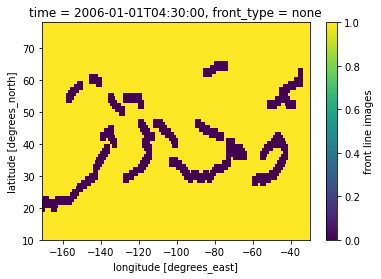

In [16]:
merra_MN_fronts = xr.open_dataset('/glade/work/kdagon/FrontDetector/MERRAOutputs/merra_fronts_2000-2015_MaskedNetCDF.nc')
merra_MN_fronts.fronts.sel(time='2006-01-01',front=4)[1,:,:].plot();

In [11]:
merra_MN_fronts

<xarray.Dataset>
Dimensions:     (front: 5, lat: 68, lon: 141, time: 46752)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01T01:30:00 ... 2015-12-31T22:30:00
    front_type  (front) object ...
  * lon         (lon) float64 -170.5 -169.5 -168.5 -167.5 ... -32.5 -31.5 -30.5
  * lat         (lat) float64 10.5 11.5 12.5 13.5 14.5 ... 74.5 75.5 76.5 77.5
Dimensions without coordinates: front
Data variables:
    crs         float64 ...
    fronts      (time, front, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    institution:  North Carolina Institute for Climate Studies (NCICS)
    title:        Coded surface bulletins with masking on a merra2-1deg grid.
    history:      2021-05-18T15:35:40.063819: jsonPolysToMaskedNetCDF.py -w 3...

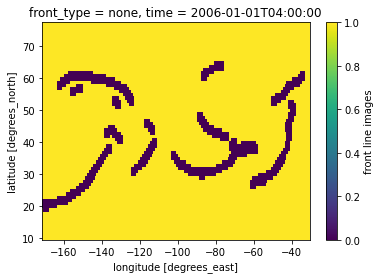

In [13]:
merra_MN_fronts_v2 = xr.open_dataset('/glade/work/kdagon/FrontDetector/MERRAOutputs/merra2_merra2-1deg_3wide_2006.nc')
merra_MN_fronts_v2.fronts.isel(time=4,front=4)[:,:].plot();

In [7]:
merra_MN_fronts_v2

<xarray.Dataset>
Dimensions:     (front: 5, lat: 68, lon: 141, time: 8760)
Coordinates:
  * lat         (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    front_type  (front) object ...
  * lon         (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * time        (time) datetime64[ns] 2006-01-01 ... 2006-12-31T23:00:00
Dimensions without coordinates: front
Data variables:
    crs         float64 ...
    fronts      (time, front, lat, lon) float32 ...
Attributes:
    title:        Coded surface bulletins with masking on a merra2-1deg grid.
    history:      2019-03-07T17:00:12.387112: ./../Python/jsonPolysToMaskedNe...
    institution:  North Carolina Institute for Climate Studies (NCICS)
    Conventions:  CF-1.7

## Function to calculate seasonal rate climatologies

In [4]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def srates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    srates_clim = rates_fronts.seasonal_rate_climatology
    srates_clim_stdev = rates_fronts.seasonal_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(srates_clim_CONUS.lat))
    weights.name = "weights"
    srates_clim_CONUS_weighted = srates_clim_CONUS.weighted(weights)
    srates_clim_CONUS_weighted_mean = srates_clim_CONUS_weighted.mean(("lon","lat"))
    srates_clim_stdev_CONUS_weighted = srates_clim_stdev_CONUS.weighted(weights)
    srates_clim_stdev_CONUS_weighted_mean = srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(srates_clim_CONUS, srates_clim_stdev_CONUS, srates_clim_CONUS_weighted_mean, srates_clim_stdev_CONUS_weighted_mean)

### Coded Surface Bulletin

In [5]:
csb_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
csb_masked_rates_file = "codsus_masked_frontRates_2003-2015.nc" # masked to compare with Jim's analysis
csb_masked_srates_clim_CONUS, csb_masked_srates_clim_stdev_CONUS, csb_masked_srates_clim_CONUS_mean, csb_masked_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(csb_filepath, csb_masked_rates_file, "MERRA")

In [6]:
csb_masked_srates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.32471475, 0.31300864, 0.27625354, 0.29810585])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [7]:
# sum across front types is not equal to "all" front type
csb_masked_srates_clim_CONUS_mean[:,:3].sum("front")

<xarray.DataArray (seasons4: 4)>
array([0.4494713 , 0.4426034 , 0.40918392, 0.41450852])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
Dimensions without coordinates: seasons4

In [8]:
csb_masked_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.06057323, 0.0554856 , 0.05437348, 0.04427692])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [9]:
csb_rates_file = "codsus_frontRates_2003-2015.nc" # unmasked to compare with CESM output
csb_srates_clim_CONUS, csb_srates_clim_stdev_CONUS, csb_srates_clim_CONUS_mean, csb_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")
csb_srates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.3131632 , 0.29544709, 0.2489845 , 0.27799668])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [10]:
csb_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.05933122, 0.05412225, 0.04911411, 0.04307559])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

### CESM

In [11]:
cesm_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
#cesm_hist_rates_file = "cesm_frontRates_2000-2005.nc" # CESM historial simulation, 2000-2005
cesm_rates_file = "cesm_fronts_2003-2015_frontRates_viaPolylines_v2.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)

cesm_srates_clim_CONUS, cesm_srates_clim_stdev_CONUS, cesm_srates_clim_CONUS_mean, cesm_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rates_file, "MERRA")
cesm_srates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.2967774 , 0.29961199, 0.25056846, 0.27474856])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [12]:
cesm_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.04847854, 0.04715109, 0.04629582, 0.04579892])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [13]:
cesm_OH_rates_file = "cesm_frontRates_2003-2015.nc" # rates calculated via one-hot files
cesm_OH_srates_clim_CONUS, cesm_OH_srates_clim_stdev_CONUS, cesm_OH_srates_clim_CONUS_mean, cesm_OH_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_OH_rates_file, "CESM")
cesm_OH_srates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.25585832, 0.24765822, 0.19533944, 0.22832437])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [15]:
cesm_OH_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.04664363, 0.04370036, 0.04110855, 0.04265401])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

### Compare CSB / CESM, 2003-2015

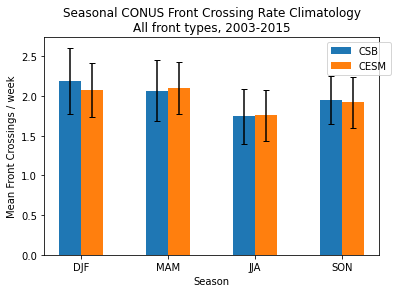

In [97]:
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w/2)
ax.bar(position, (cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

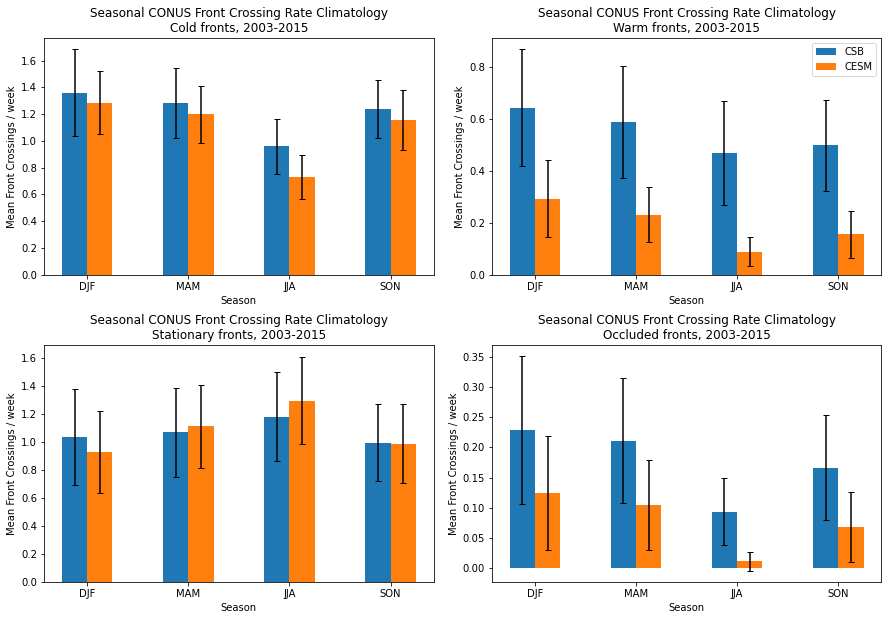

In [98]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, (csb_srates_clim_CONUS_mean*7)[:,i], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="CSB", color='C0', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, (cesm_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="CESM", color='C1', capsize=3)

    ax[i].set_title('Seasonal CONUS Front Crossing Rate Climatology\n'+frontstrings[i]+' fronts, 2003-2015')
    ax[i].set_ylabel('Mean Front Crossings / week')
    ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')

### MERRA

In [16]:
merra_filepath = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
merra_rates_file = "merra_fronts_2003-2015_frontRates_viaPolylines.nc"

merra_srates_clim_CONUS, merra_srates_clim_stdev_CONUS, merra_srates_clim_CONUS_mean, merra_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_rates_file, "MERRA")
merra_srates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.30447089, 0.30205671, 0.26240871, 0.27518556])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [17]:
merra_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.05121827, 0.04926218, 0.04555611, 0.04129746])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [19]:
merra_OH_rates_file = "merra_frontRates_2003-2015.nc"
merra_OH_srates_clim_CONUS, merra_OH_srates_clim_stdev_CONUS, merra_OH_srates_clim_CONUS_mean, merra_OH_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_OH_rates_file, "CESM")
merra_OH_srates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.26238762, 0.25403579, 0.21019756, 0.23062395])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [20]:
merra_OH_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.04978789, 0.04618768, 0.04048906, 0.03805828])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

## Function to calculate monthly rate climatologies

In [3]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def mrates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    mrates_clim = rates_fronts.monthly_rate_climatology
    mrates_clim_stdev = rates_fronts.monthly_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        mrates_clim_CONUS = mrates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        mrates_clim_stdev_CONUS = mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        mrates_clim_CONUS = mrates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        mrates_clim_stdev_CONUS = mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(mrates_clim_CONUS.lat))
    weights.name = "weights"
    mrates_clim_CONUS_weighted = mrates_clim_CONUS.weighted(weights)
    mrates_clim_CONUS_weighted_mean = mrates_clim_CONUS_weighted.mean(("lon","lat"))
    mrates_clim_stdev_CONUS_weighted = mrates_clim_stdev_CONUS.weighted(weights)
    mrates_clim_stdev_CONUS_weighted_mean = mrates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(mrates_clim_CONUS, mrates_clim_stdev_CONUS, mrates_clim_CONUS_weighted_mean, mrates_clim_stdev_CONUS_weighted_mean)

### Coded Surface Bulletin

In [4]:
csb_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
csb_masked_rates_file = "codsus_masked_frontRates_2003-2015.nc" # masked to compare with Jim's analysis
csb_masked_mrates_clim_CONUS, csb_masked_mrates_clim_stdev_CONUS, csb_masked_mrates_clim_CONUS_mean, csb_masked_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_masked_rates_file, "MERRA")

In [5]:
csb_masked_mrates_clim_CONUS_mean[:,4]

<xarray.DataArray (months12: 12)>
array([0.32542861, 0.33313927, 0.32790412, 0.3156102 , 0.29597814,
       0.28475821, 0.26452851, 0.27977858, 0.28293724, 0.30587063,
       0.30527712, 0.31633233])
Coordinates:
    clim_months  (months12) datetime64[ns] 2009-01-15 2009-02-15 ... 2009-12-15
    front_type   object 'all'
Dimensions without coordinates: months12

In [6]:
# sum across front types is not equal to "all" front type
csb_masked_mrates_clim_CONUS_mean[:,:3].sum("front")

<xarray.DataArray (months12: 12)>
array([0.44822669, 0.45941767, 0.45976823, 0.43984488, 0.4283575 ,
       0.41597797, 0.39707238, 0.41476198, 0.40418286, 0.42011861,
       0.41905507, 0.44164716])
Coordinates:
    clim_months  (months12) datetime64[ns] 2009-01-15 2009-02-15 ... 2009-12-15
Dimensions without coordinates: months12

In [7]:
csb_masked_mrates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (months12: 12)>
array([0.08350155, 0.09031117, 0.09087807, 0.08097453, 0.08650881,
       0.08864373, 0.0853154 , 0.08789762, 0.07612684, 0.07697069,
       0.07093639, 0.08582684])
Coordinates:
    clim_months  (months12) datetime64[ns] 2009-01-15 2009-02-15 ... 2009-12-15
    front_type   object 'all'
Dimensions without coordinates: months12

In [8]:
csb_rates_file = "codsus_frontRates_2003-2015.nc" # unmasked to compare with CESM output
csb_mrates_clim_CONUS, csb_mrates_clim_stdev_CONUS, csb_mrates_clim_CONUS_mean, csb_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")
csb_mrates_clim_CONUS_mean[:,4]

<xarray.DataArray (months12: 12)>
array([0.31044127, 0.32194335, 0.31231662, 0.29970892, 0.2749303 ,
       0.25903856, 0.23710637, 0.25115637, 0.25697145, 0.28698905,
       0.28976578, 0.30786813])
Coordinates:
    clim_months  (months12) datetime64[ns] 2009-01-15 2009-02-15 ... 2009-12-15
    front_type   object 'all'
Dimensions without coordinates: months12

In [9]:
csb_mrates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (months12: 12)>
array([0.08330001, 0.08703383, 0.08898776, 0.07833854, 0.08185299,
       0.0815198 , 0.07592456, 0.07868185, 0.07127922, 0.07455   ,
       0.06990523, 0.08475019])
Coordinates:
    clim_months  (months12) datetime64[ns] 2009-01-15 2009-02-15 ... 2009-12-15
    front_type   object 'all'
Dimensions without coordinates: months12

### Compare CSB / CESM

In [71]:
csb_mrates_clim_CONUS, csb_mrates_clim_stdev_CONUS, csb_mrates_clim_CONUS_mean, csb_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")
cesm_mrates_clim_CONUS, cesm_mrates_clim_stdev_CONUS, cesm_mrates_clim_CONUS_mean, cesm_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_rates_file, "MERRA")

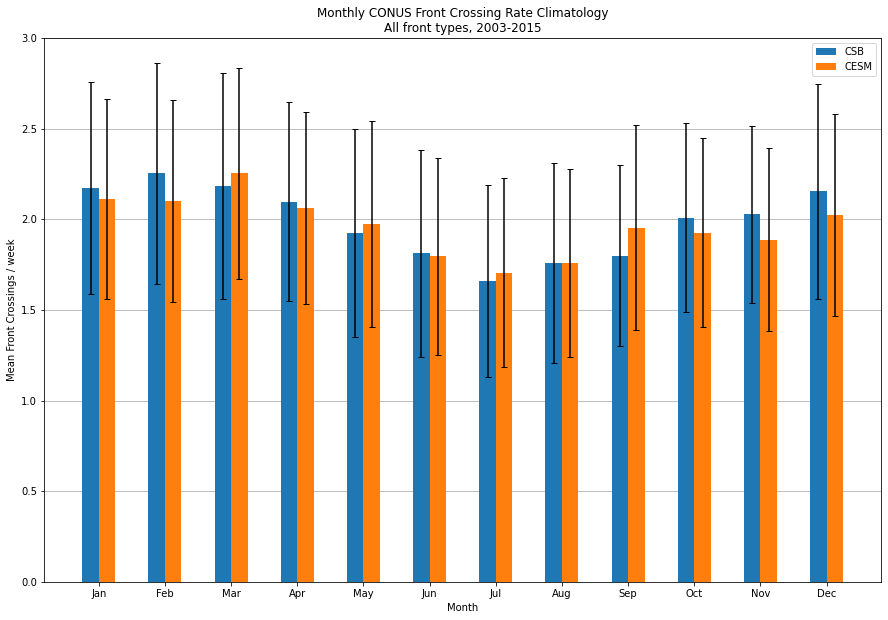

In [92]:
fig, ax = plt.subplots(figsize=(15,10))

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
ax.bar(position, (csb_mrates_clim_CONUS_mean*7)[:,4], yerr=(csb_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, (cesm_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

# use unmasked csb to compare with cesm; masked csb to compare with Jim's paper
#plt.savefig('../figures/csb_cesm_mrates_clim_CONUS_mean_wk.png', bbox_inches='tight')
#plt.savefig('../figures/csb_cesm_mrates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')
#plt.savefig('../figures/csb_masked_cesm_mrates_clim_CONUS_mean_wk.png', bbox_inches='tight')

## Debugging the standard deviation discrepancy

<xarray.DataArray ()>
array(0.08330001)
Coordinates:
    clim_months  datetime64[ns] 2009-01-15
    front_type   object 'all'

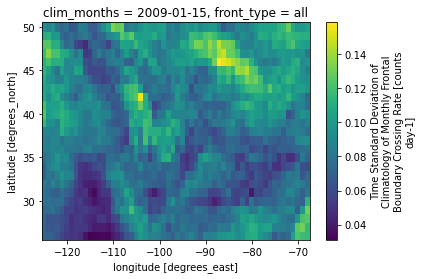

In [78]:
# look spatially at stdev counts per day - order of magnitude looks right for the spatial mean
csb_mrates_clim_stdev_CONUS[0,4,:,:].plot();
csb_mrates_clim_stdev_CONUS_mean[0,4]

In [81]:
# calculate the stdev manually based on monthly rate
csb_mrates = csb_rates_fronts.monthly_rate
csb_mrates_std = csb_mrates.groupby("months.month").std("months")
csb_mrates_std_CONUS = csb_mrates_std.sel(lat=slice(26,50), lon=slice(-125, -68))
weights = np.cos(np.deg2rad(csb_mrates_std_CONUS.lat))
weights.name = "weights"
csb_mrates_std_CONUS_weighted = csb_mrates_std_CONUS.weighted(weights)
csb_mrates_std_CONUS_weighted_mean = csb_mrates_std_CONUS_weighted.mean(("lon","lat"))
csb_mrates_std_CONUS_weighted_mean[:,4]

<xarray.DataArray (month: 12)>
array([0.08330001, 0.08703383, 0.08898776, 0.07833854, 0.08185299,
       0.0815198 , 0.07592456, 0.07868185, 0.07127922, 0.07455   ,
       0.06990523, 0.08475019])
Coordinates:
    front_type  object 'all'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

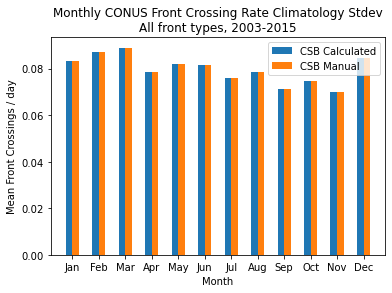

In [83]:
# comparing stdev (calculated/manual) - they are the same!
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, csb_mrates_clim_stdev_CONUS_mean[:,4], width=w, label="CSB Calculated", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, csb_mrates_std_CONUS_weighted_mean[:,4], width=w, label="CSB Manual", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology Stdev\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / day')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

In [85]:
# read in the csb files directly
csb_narr_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/NARR/"
csb_narr_rates_file = "codsus_masked_narr-96km_rates_2003-2015.nc" # downloaded directly from Jim's paper (not calculated)
csb_narr_rates_fronts = xr.open_dataset(csb_narr_filepath+csb_narr_rates_file)

In [86]:
csb_narr_rates_fronts.monthly_rate_climatology_stdev

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12, front: 5, y: 92, x: 116)>
[640320 values with dtype=float32]
Coordinates:
  * y           (y) float64 2.724e+04 1.247e+05 2.222e+05 ... 8.802e+06 8.9e+06
  * x           (x) float64 2.61e+04 1.236e+05 2.211e+05 ... 1.114e+07 1.124e+07
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    front_type  (front) object ...
Dimensions without coordinates: months12, front
Attributes:
    grid_mapping:  crs
    long_name:     Time Standard Deviation of Climatology of Monthly Frontal ...
    valid_min:     0
    cell_methods:  time: standard_deviation within years time: standard_devia...
    units:         counts day-1
    valid_max:     31

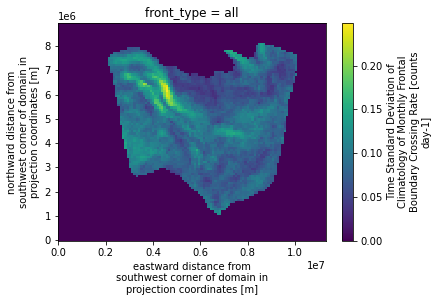

In [87]:
# note different coordinates here...
csb_narr_rates_fronts.monthly_rate_climatology_stdev[0,4,:,:].plot();
# units are per day...the numbers in Jim's spreadsheet look very small compare to this plot (stdev=0.02 events/day)

In [88]:
# rough spatial mean including all the zeros - is that what's driving the low values?
csb_narr_rates_fronts.monthly_rate_climatology_stdev.mean(('x','y'))[:,4]

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12)>
array([0.03276861, 0.03517324, 0.03330119, 0.03229036, 0.03223196,
       0.0311469 , 0.03128187, 0.03072169, 0.02950566, 0.03100442,
       0.03120891, 0.03329951], dtype=float32)
Coordinates:
    front_type  object 'all'
Dimensions without coordinates: months12

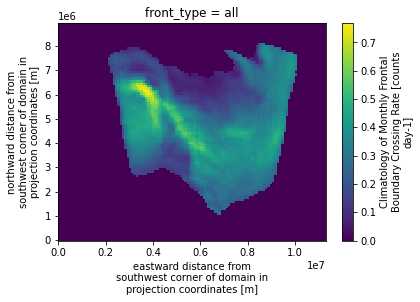

In [89]:
# look at the rates - looks similar (per day)
csb_narr_rates_fronts.monthly_rate_climatology[0,4,:,:].plot();

## Debugging the gridding artifacts

In [99]:
# investigate the MaskedNetCDF files versus the OneHot files
cesm_MaskedNetCDF_file = "cesm_fronts_2000-2015_MaskedNetCDF_v2.nc"
cesm_OneHot_file = "cesm_frontsOneHot_2000-2015.nc"

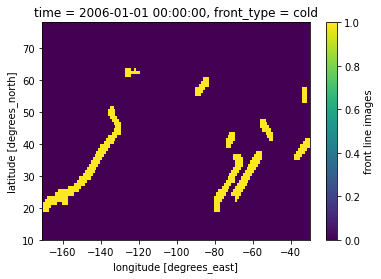

In [102]:
cesm_MN_fronts = xr.open_dataset(cesm_filepath+cesm_MaskedNetCDF_file)
cesm_MN_fronts.fronts.sel(time='2006-01-01',front=0)[0,:,:].plot();

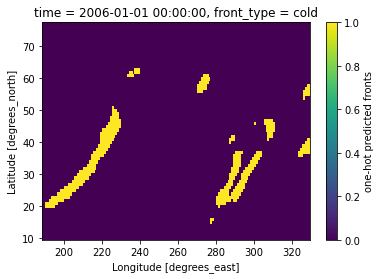

In [104]:
cesm_OH_fronts = xr.open_dataset(cesm_filepath+cesm_OneHot_file)
cesm_OH_fronts.fronts.sel(time='2006-01-01',front=0)[0,:,:].plot();

How is OH file different?
For some reason when run through the rates calculator, the spatial mapping is very spotty for MN

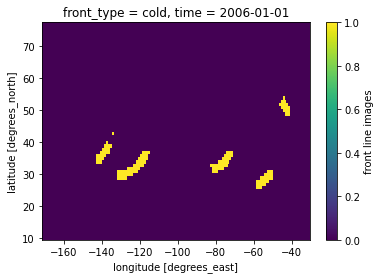

In [108]:
# look at a CSB MaskedNetCDF file (downloaded not processed)
csb_MaskedNetCDF_file = "codsus_merra2-1deg_3wide_2006.nc"
csb_MN_fronts = xr.open_dataset(csb_filepath+csb_MaskedNetCDF_file)
csb_MN_fronts.fronts.sel(time='2006-01-01',front=0)[0,:,:].plot();

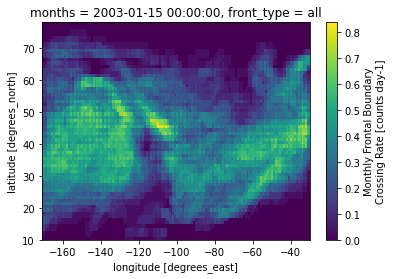

In [107]:
# look at the rates file again, start from the least amount of time averaging (monthly rate)
cesm_rates_fronts.monthly_rate[0,4,:,:].plot();

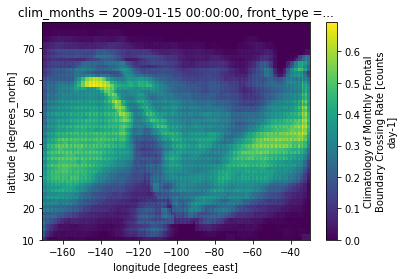

In [109]:
cesm_rates_fronts.monthly_rate_climatology[0,4,:,:].plot();

Looks like it might be in the transiton from rate --> climatology? But doesn't happen in rates generated from OH

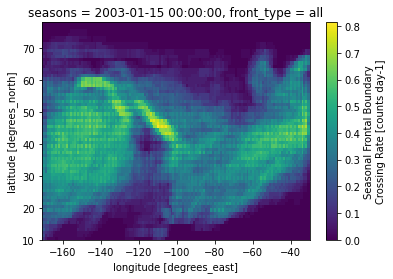

In [110]:
cesm_rates_fronts.seasonal_rate[0,4,:,:].plot();

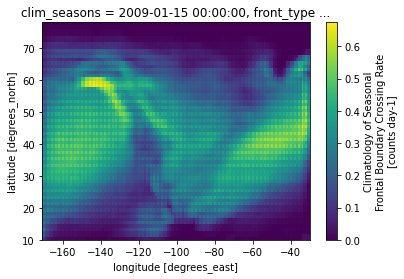

In [111]:
cesm_rates_fronts.seasonal_rate_climatology[0,4,:,:].plot();

In [113]:
# grab the old rates file
cesm_rates_OH_file = "cesm_frontRates_2003-2015.nc"
cesm_rates_OH_fronts = xr.open_dataset(cesm_filepath+cesm_rates_OH_file)
cesm_srates_OH_clim = cesm_rates_OH_fronts.seasonal_rate_climatology
cesm_srates_OH_clim_CONUS = cesm_srates_OH_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_srates_OH_clim_CONUS_wk = cesm_srates_OH_clim_CONUS*7

In [114]:
cesm_srates_OH_clim_stdev = cesm_rates_OH_fronts.seasonal_rate_climatology_stdev
cesm_srates_OH_clim_stdev_CONUS = cesm_srates_OH_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_srates_OH_clim_stdev_CONUS_wk = cesm_srates_OH_clim_stdev_CONUS*7

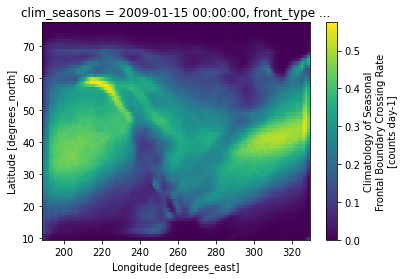

In [116]:
cesm_rates_OH_fronts.seasonal_rate_climatology[0,4,:,:].plot();

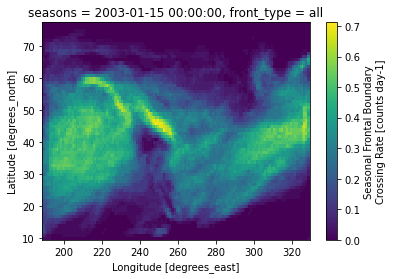

In [117]:
cesm_rates_OH_fronts.seasonal_rate[0,4,:,:].plot();

why is it so much smoother? 

In [121]:
csb_srates_clim_CONUS

<xarray.DataArray 'seasonal_rate_climatology' (seasons4: 4, front: 5, lat: 25, lon: 58)>
array([[[[0.093262, ..., 0.036791],
         ...,
         [0.125775, ..., 0.118075]],

        ...,

        [[0.096684, ..., 0.047059],
         ...,
         [0.413262, ..., 0.258396]]],


       ...,


       [[[0.041495, ..., 0.010162],
         ...,
         [0.160898, ..., 0.155817]],

        ...,

        [[0.041495, ..., 0.01609 ],
         ...,
         [0.3472  , ..., 0.302318]]]], dtype=float32)
Coordinates:
  * lat           (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * lon           (lon) float64 -125.0 -124.0 -123.0 ... -70.0 -69.0 -68.0
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: seasons4, front
Attributes:
    long_name:     Climatology of Seasonal Frontal Boundary Crossing Rate
    cell_methods:  time: mean within years time: mean over years
    valid_min:     0
    valid_max:     92
    grid_mapping:  crs
    units:         counts day-1

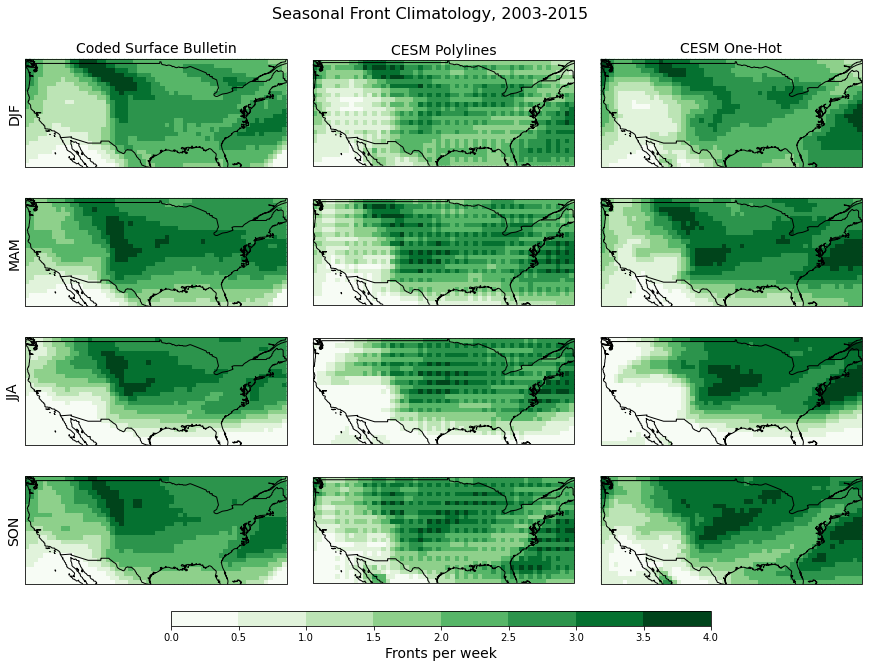

In [123]:
# try plotting with an explicit colorbar as in Jim's Fig 6

# by season type and trim domain to CONUS
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    lat = csb_srates_clim_CONUS.lat
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    # see also: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html#differences-pcolor-pcolormesh
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)
 

for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CESM Polylines', fontsize=14)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    lat = cesm_srates_clim_CONUS.lat
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# also compare CESM rates via OneHot file
for i in range(nsea):
    if i == 0:
        axs[i,2].set_title('CESM One-Hot', fontsize=14)
    field, lon = add_cyclic_point(cesm_srates_OH_clim_CONUS_wk[i,4,:,:], coord=cesm_srates_OH_clim_CONUS.lon)
    lat = cesm_srates_OH_clim_CONUS.lat
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,2].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
#cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_viaPoly_OH.png')

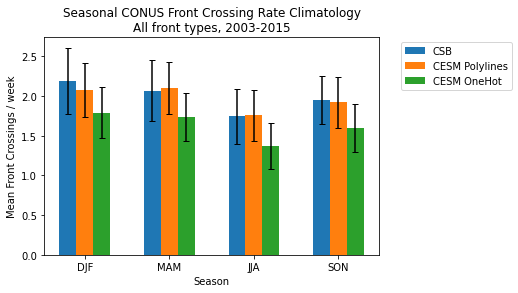

In [127]:
# compare seasonal climatological spatial averages across 3 datasets
fig, ax = plt.subplots()

w = 0.2
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# set number of bars per x label to find optimal positions
nbars=3

position = x + (w*(1-nbars)/2) + 0*w
ax.bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w*(1-nbars)/2) + 1*w
ax.bar(position, (cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM Polylines", color='C1', capsize=3)
position = x + (w*(1-nbars)/2) + 2*w
ax.bar(position, (cesm_OH_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM OneHot", color='C2', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/csb_cesm_PolyOH_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

## CESM historial simulation front rates

In [21]:
cesm_hist_rates_file = "cesm_frontRates_2000-2005.nc"

In [22]:
cesm_hist_rates_fronts = xr.open_dataset(cesm_filepath+cesm_hist_rates_file)

In [23]:
cesm_hist_rates_fronts

<xarray.Dataset>
Dimensions:                          (bnds: 2, front: 5, lat: 68, lon: 141, months: 72, months12: 12, seasons: 25, seasons4: 4, total: 1, years: 6)
Coordinates:
  * lat                              (lat) float64 10.0 11.0 12.0 ... 76.0 77.0
  * lon                              (lon) float64 189.0 190.0 ... 328.0 329.0
  * months                           (months) object 2000-01-15 00:00:00 ... 2005-12-15 00:00:00
    clim_months                      (months12) object ...
  * seasons                          (seasons) object 2000-01-15 00:00:00 ... 2005-12-15 00:00:00
    clim_seasons                     (seasons4) object ...
  * years                            (years) object 2000-07-15 00:00:00 ... 2005-07-15 00:00:00
    front_type                       (front) object ...
Dimensions without coordinates: bnds, front, months12, seasons4, total
Data variables:
    month_bounds                     (months, bnds) object ...
    clim_month_bounds                (months12, bnds) float64 ...
    season_bounds                    (seasons, bnds) object ...
    clim_season_bounds               (seasons4, bnds) float64 ...
    year_bounds                      (years, bnds) object ...
    total_time                       (total) object ...
    total_time_bounds                (total, bnds) object ...
    monthly_rate                     (months, front, lat, lon) float32 ...
    monthly_rate_anomaly             (months, front, lat, lon) float32 ...
    monthly_rate_climatology         (months12, front, lat, lon) float32 ...
    monthly_rate_climatology_stdev   (months12, front, lat, lon) float32 ...
    seasonal_rate                    (seasons, front, lat, lon) float32 ...
    seasonal_rate_anomaly            (seasons, front, lat, lon) float32 ...
    seasonal_rate_climatology        (seasons4, front, lat, lon) float32 ...
    seasonal_rate_climatology_stdev  (seasons4, front, lat, lon) float32 ...
    annual_rate                      (years, front, lat, lon) float32 ...
    annual_rate_anomaly              (years, front, lat, lon) float32 ...
    total_rate                       (total, front, lat, lon) float32 ...
    total_rate_stdev                 (total, front, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Monthly, Annual, and Mean Frontal Boundary Crossing Rates
    summary:      This file contains grids showing rates of frontal boundary ...

In [24]:
# seasonal centers? i.e., DJF center is Jan 15?
cesm_hist_rates_fronts.clim_seasons

<xarray.DataArray 'clim_seasons' (seasons4: 4)>
array([cftime.DatetimeNoLeap(2003, 1, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 4, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 7, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 10, 15, 0, 0, 0, 0)], dtype=object)
Coordinates:
    clim_seasons  (seasons4) object 2003-01-15 00:00:00 ... 2003-10-15 00:00:00
Dimensions without coordinates: seasons4
Attributes:
    axis:           T
    long_name:      climatology seasons
    standard_name:  time
    climatology:    clim_season_bounds

In [25]:
# last front index is "all"
cesm_hist_rates_fronts.front_type

<xarray.DataArray 'front_type' (front: 5)>
array(['cold', 'warm', 'stationary', 'occluded', 'all'], dtype=object)
Coordinates:
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: front
Attributes:
    long_name:  kind of front

In [27]:
# seasonal rate climo
cesm_hist_srates_clim = cesm_hist_rates_fronts.seasonal_rate_climatology

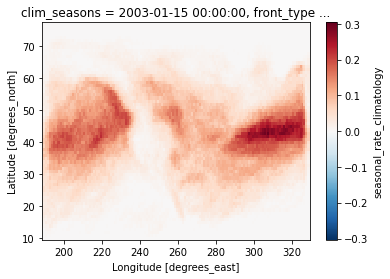

In [28]:
# how different is the sum of the front types versus the 'all' front type?
diffcheck = cesm_hist_srates_clim[:,:4,:,:].sum('front') - cesm_hist_srates_clim[:,4,:,:]
diffcheck[0,:,:].plot();

In [29]:
# CONUS region
cesm_hist_srates_clim_CONUS = cesm_hist_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons

In [32]:
# weighted spatial mean
weights = np.cos(np.deg2rad(cesm_hist_srates_clim_CONUS.lat))
weights.name = "weights"
cesm_hist_srates_clim_CONUS_weighted = cesm_hist_srates_clim_CONUS.weighted(weights)
cesm_hist_srates_clim_CONUS_weighted_mean_wk = cesm_hist_srates_clim_CONUS_weighted.mean(("lon","lat"))*7 # convert counts/day to counts/wk

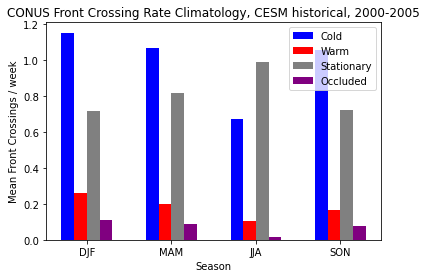

In [35]:
# plot front rates by type
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CESM historical, 2000-2005')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_hist_srates_clim_CONUS_mean_wk.png')

## CESM continuation: RCP2.6, 2006-2015

In [36]:
cesm_rcp_rates_file = "cesm_frontRates_2006-2015.nc"

In [37]:
cesm_rcp_rates_fronts = xr.open_dataset(cesm_filepath+cesm_rcp_rates_file)

In [38]:
cesm_rcp_srates_clim = cesm_rcp_rates_fronts.seasonal_rate_climatology
cesm_rcp_srates_clim_CONUS = cesm_rcp_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_rcp_srates_clim_CONUS_weighted = cesm_rcp_srates_clim_CONUS.weighted(weights)
cesm_rcp_srates_clim_CONUS_weighted_mean_wk = cesm_rcp_srates_clim_CONUS_weighted.mean(("lon","lat"))*7 # convert counts/day to counts/wk

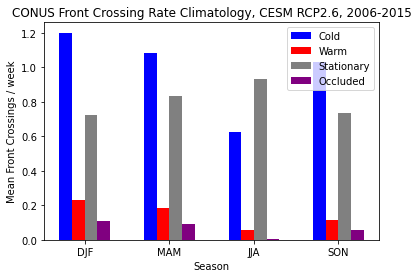

In [39]:
# plot front rates by type
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CESM RCP2.6, 2006-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_rcp_srates_clim_CONUS_mean_wk.png')

## Validation data: Coded Surface Bulletin fronts

In [59]:
csb_rates_file = "codsus_frontRates_2003-2015.nc" # unmasked version to compare with CESM/MERRA
#csb_rates_file = "codsus_masked_frontRates_2003-2015.nc" # masked version to compare with Jim's analysis
# NOTE: masking is really just cutting out extreme SW US which doesn't have that many fronts anyway, so the CONUS averages should look similar for CSB masked/unmasked
#csb_rates_file = "codsus_1wide_frontRates_2003-2015.nc" # testing the 1wide version - makes a big difference!

In [60]:
csb_rates_fronts = xr.open_dataset(csb_filepath+csb_rates_file)

In [61]:
csb_srates_clim = csb_rates_fronts.seasonal_rate_climatology

In [62]:
# approx. lat/lon here to get a CONUS rectangular region
csb_srates_clim_CONUS = csb_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons

In [63]:
weights = np.cos(np.deg2rad(csb_srates_clim_CONUS.lat))
weights.name = "weights"
csb_srates_clim_CONUS_weighted = csb_srates_clim_CONUS.weighted(weights)
csb_srates_clim_CONUS_weighted_mean_wk = csb_srates_clim_CONUS_weighted.mean(("lon","lat"))*7

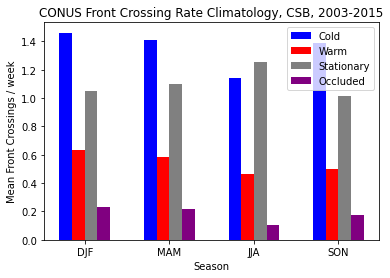

In [49]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CSB, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/csb_srates_clim_CONUS_mean_wk.png')
#plt.savefig('../figures/csb_masked_srates_clim_CONUS_mean_wk.png')
#plt.savefig('../figures/csb_1wide_srates_clim_CONUS_mean_wk.png')

## Combine CESM output 2003-2015 to compare with the same obs years

In [50]:
#cesm_rates_file = "cesm_frontRates_2003-2015.nc"
cesm_rates_file = "cesm_fronts_2003-2015_frontRates_viaPolylines.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
cesm_rates_fronts = xr.open_dataset(cesm_filepath+cesm_rates_file)

In [51]:
cesm_srates_clim = cesm_rates_fronts.seasonal_rate_climatology
#cesm_srates_clim_CONUS = cesm_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_srates_clim_CONUS = cesm_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
weights = np.cos(np.deg2rad(cesm_srates_clim_CONUS.lat))
weights.name = "weights"
cesm_srates_clim_CONUS_weighted = cesm_srates_clim_CONUS.weighted(weights)
cesm_srates_clim_CONUS_weighted_mean_wk = cesm_srates_clim_CONUS_weighted.mean(("lon","lat"))*7

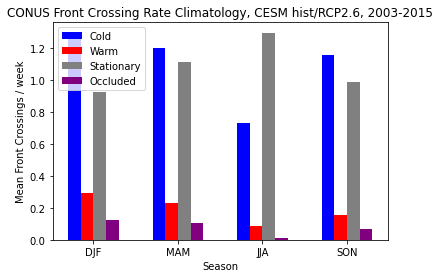

In [52]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CESM hist/RCP2.6, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_srates_clim_CONUS_mean_wk.png')

## Compare CSB / CESM, 2003-2015

In [54]:
# standard deviation across fronts for each season
np.std(cesm_srates_clim_CONUS_weighted_mean_wk[:,:4], axis=1)

<xarray.DataArray (seasons4: 4)>
array([0.4705877 , 0.49649307, 0.52228492, 0.48471153])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
Dimensions without coordinates: seasons4

In [64]:
# standard deviation across time (years) is already a calculated quantity
csb_srates_clim_stdev = csb_rates_fronts.seasonal_rate_climatology_stdev
csb_srates_clim_stdev_CONUS = csb_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
weights = np.cos(np.deg2rad(csb_srates_clim_CONUS.lat))
weights.name = "weights"
csb_srates_clim_stdev_CONUS_weighted = csb_srates_clim_stdev_CONUS.weighted(weights)
csb_srates_clim_stdev_CONUS_weighted_mean_wk = csb_srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))*7
csb_srates_clim_stdev_CONUS_weighted_mean_wk[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.41531851, 0.37885576, 0.34379879, 0.30152915])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [57]:
cesm_srates_clim_stdev = cesm_rates_fronts.seasonal_rate_climatology_stdev
cesm_srates_clim_stdev_CONUS = cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
weights = np.cos(np.deg2rad(cesm_srates_clim_CONUS.lat))
weights.name = "weights"
cesm_srates_clim_stdev_CONUS_weighted = cesm_srates_clim_stdev_CONUS.weighted(weights)
cesm_srates_clim_stdev_CONUS_weighted_mean_wk = cesm_srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))*7
cesm_srates_clim_stdev_CONUS_weighted_mean_wk[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.33938423, 0.33005762, 0.32407072, 0.32059247])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

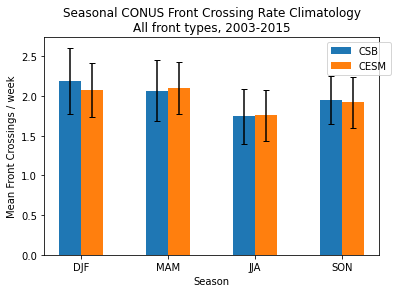

In [66]:
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
# summing across the first 4 front indices does not equal the 5th index (front/no-front)
#ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,:4].sum("front"), width=w, label="CSB", color='C0')
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,4], yerr=csb_srates_clim_stdev_CONUS_weighted_mean_wk[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w/2)
#ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk[:,:4].sum("front"), width=w, label="CESM", color='C1')
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk[:,4], yerr=cesm_srates_clim_stdev_CONUS_weighted_mean_wk[:,4], width=w, label="CESM", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_mean_wk.png', bbox_inches='tight')
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

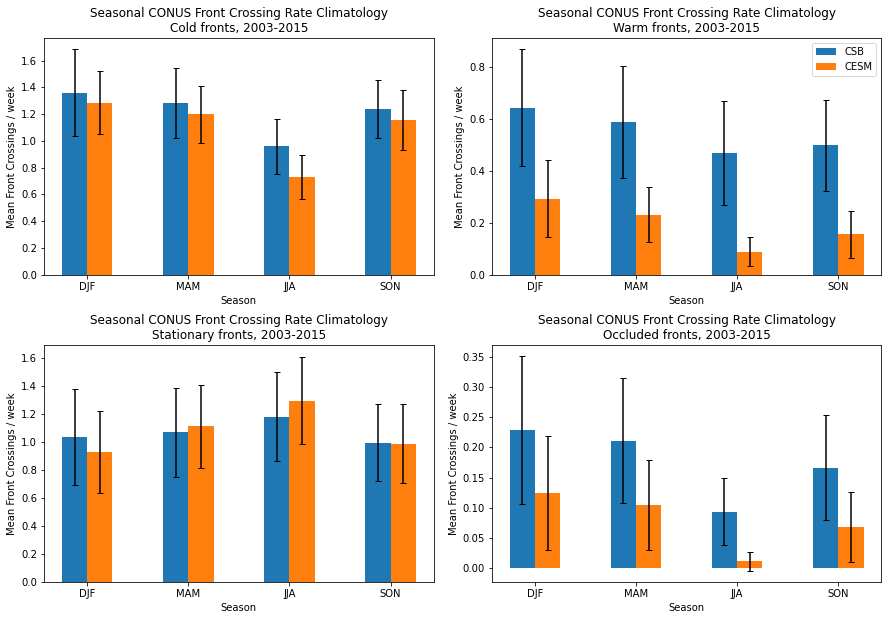

In [93]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,i], yerr=csb_srates_clim_stdev_CONUS_weighted_mean_wk[:,i], width=w, label="CSB", color='C0', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, cesm_srates_clim_CONUS_weighted_mean_wk[:,i], yerr=cesm_srates_clim_stdev_CONUS_weighted_mean_wk[:,i], width=w, label="CESM", color='C1', capsize=3)

    ax[i].set_title('Seasonal CONUS Front Crossing Rate Climatology\n'+frontstrings[i]+' fronts, 2003-2015')
    ax[i].set_ylabel('Mean Front Crossings / week')
    ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_mean_wk_byfronttype.png', bbox_inches='tight')
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')

## Spatial Maps of Seasonal Climatology

In [83]:
cesm_srates_clim_wk = cesm_srates_clim*7
cesm_srates_clim_CONUS_wk = cesm_srates_clim_CONUS*7

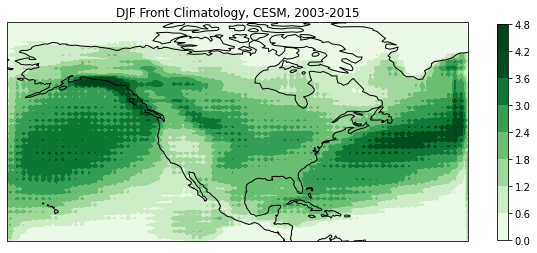

In [84]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

# start with the first season (DJF)
field, lon = add_cyclic_point(cesm_srates_clim_wk[0,4,:,:], coord=cesm_srates_clim.lon)
lat = cesm_srates_clim.lat

cf = ax.contourf(lon, lat, field, vmin=0, vmax=4, cmap=cm.Greens, transform=ccrs.PlateCarree())
#cf = ax.pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation

ax.set_title('DJF Front Climatology, CESM, 2003-2015')
ax.coastlines()

plt.colorbar(cf, shrink=0.5);

In [36]:
csb_srates_clim_wk = csb_srates_clim*7
csb_srates_clim_CONUS_wk = csb_srates_clim_CONUS*7

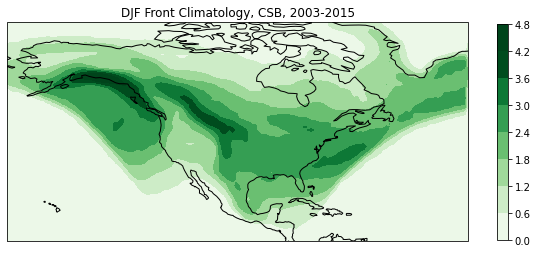

In [86]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

# start with the first season (DJF)
field, lon = add_cyclic_point(csb_srates_clim_wk[0,4,:,:], coord=csb_srates_clim.lon)
lat = csb_srates_clim.lat

cf = ax.contourf(lon, lat, field, vmin=0, vmax=4, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation
ax.set_title('DJF Front Climatology, CSB, 2003-2015')
ax.coastlines()

plt.colorbar(cf, shrink=0.5);

# compare masked and unmasked CSB data to see the difference spatially
#plt.savefig('../figures/csb_srates_clim_DJF.png')
#plt.savefig('../figures/csb_masked_srates_clim_DJF.png')

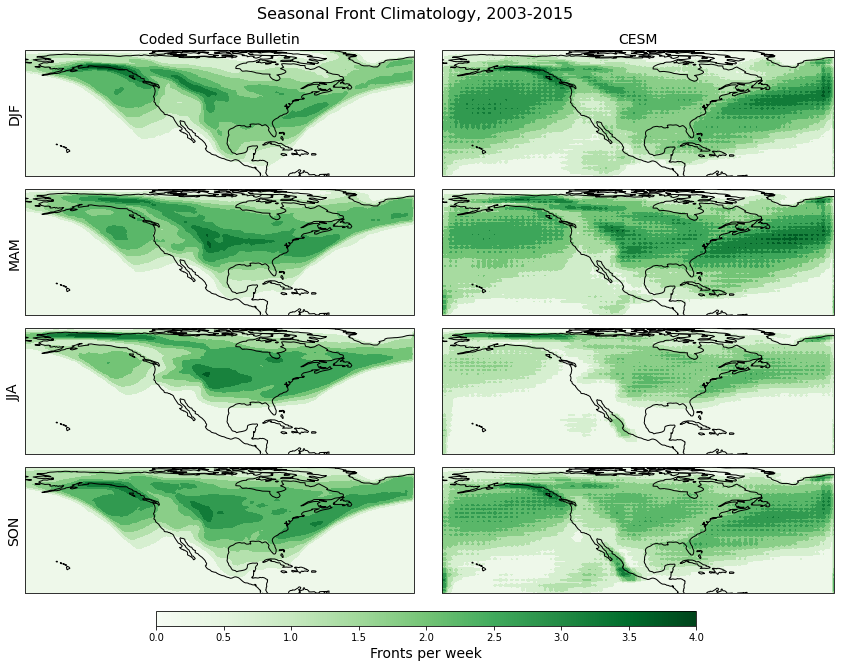

In [88]:
# by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertCylindrical()})
#axs = axs.ravel()

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point(csb_srates_clim_wk[i,4,:,:], coord=csb_srates_clim.lon)
    lat = csb_srates_clim.lat
    cf = axs[i,0].contourf(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation
    axs[i,0].coastlines()
    # can't get ylabels to work?
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CESM', fontsize=14)
    field, lon = add_cyclic_point(cesm_srates_clim_wk[i,4,:,:], coord=cesm_srates_clim.lon)
    lat = cesm_srates_clim.lat
    cf = axs[i,1].contourf(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation
    axs[i,1].coastlines()
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('srates_clim_CSB_CESM_2003-2005_lambert.pdf', bbox_inches='tight')

looks like it's the polyline method that's causing the stippling on the CESM filled coutour plots (grid issue?)

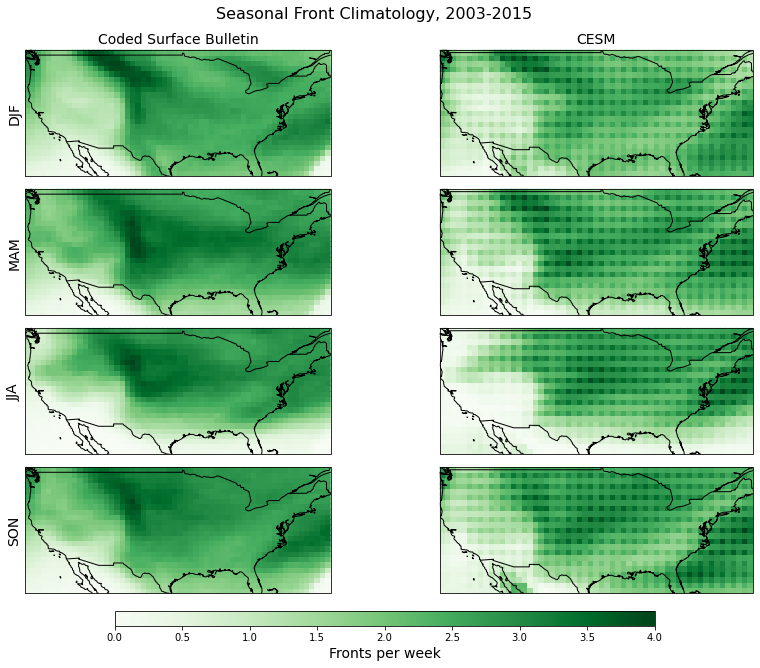

In [90]:
# by season type and trim domain to CONUS
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertCylindrical()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertConformal()}) # some of these may not be ideal for a region (the way I've subset anyway)
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.Robinson()})
#axs = axs.ravel()

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point(csb_srates_clim_CONUS_wk[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    lat = csb_srates_clim_CONUS.lat
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    # see also: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html#differences-pcolor-pcolormesh
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CESM', fontsize=14)
    field, lon = add_cyclic_point(cesm_srates_clim_CONUS_wk[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    lat = cesm_srates_clim_CONUS.lat
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree())
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('srates_clim_CSB_CESM_2003-2005_lambert.pdf', bbox_inches='tight')
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS.png')
#plt.savefig('../figures/csb_cesm_srates_clim_CONUS_viaPoly.png')

## Compare MERRA / CSB, 2003-2015

In [10]:
merra_file_path = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
merra_rates_file = "merra_fronts_2003-2015_frontRates_viaPolylines.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
merra_rates_fronts = xr.open_dataset(merra_file_path+merra_rates_file)

In [11]:
merra_srates_clim = merra_rates_fronts.seasonal_rate_climatology
merra_srates_clim_CONUS = merra_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
merra_srates_clim_CONUS_mean_wk = merra_srates_clim_CONUS.mean(("lon","lat"))*7 # convert counts/day to counts/wk

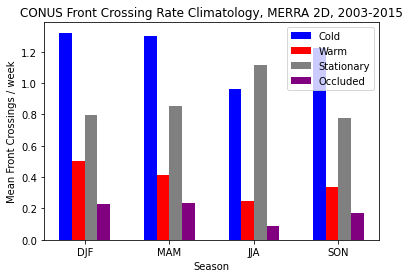

In [12]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, MERRA 2D, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_srates_clim_CONUS_mean_wk.png')

In [13]:
# error bars
merra_srates_clim_stdev = merra_rates_fronts.seasonal_rate_climatology_stdev
merra_srates_clim_stdev_CONUS = merra_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
merra_srates_clim_stdev_CONUS_mean_wk = merra_srates_clim_stdev_CONUS.mean(("lon","lat"))*7
merra_srates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.36209846, 0.34631583, 0.31974918, 0.28899708], dtype=float32)
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] ...
    front_type    object ...
Dimensions without coordinates: seasons4

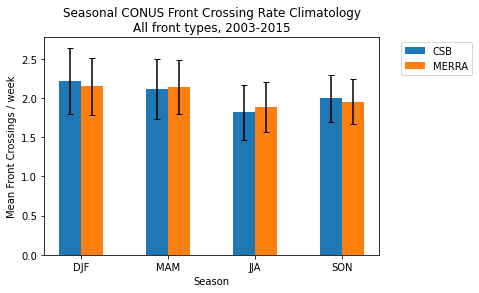

In [25]:
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, csb_srates_clim_CONUS_mean_wk[:,4], yerr=csb_srates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w/2)
ax.bar(position, merra_srates_clim_CONUS_mean_wk[:,4], yerr=merra_srates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="MERRA", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/csb_merra_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

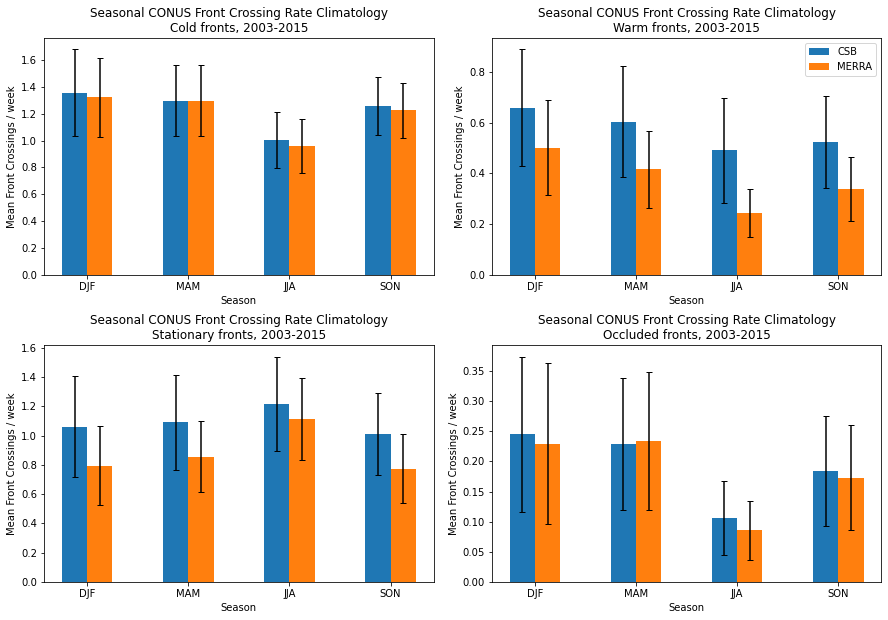

In [27]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, csb_srates_clim_CONUS_mean_wk[:,i], yerr=csb_srates_clim_stdev_CONUS_mean_wk[:,i], width=w, label="CSB", color='C0', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, merra_srates_clim_CONUS_mean_wk[:,i], yerr=merra_srates_clim_stdev_CONUS_mean_wk[:,i], width=w, label="MERRA", color='C1', capsize=3)

    ax[i].set_title('Seasonal CONUS Front Crossing Rate Climatology\n'+frontstrings[i]+' fronts, 2003-2015')
    ax[i].set_ylabel('Mean Front Crossings / week')
    ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
#plt.savefig('../figures/toSCP/csb_merra_srates_clim_CONUS_mean_wk_byfronttype_stdev.png')

In [32]:
merra_mrates_clim = merra_rates_fronts.monthly_rate_climatology
merra_mrates_clim_CONUS_mean_wk = merra_mrates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)).mean(("lon","lat"))*7

In [30]:
merra_mrates_clim_stdev = merra_rates_fronts.monthly_rate_climatology_stdev
merra_mrates_clim_stdev_CONUS_mean_wk = merra_mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68)).mean(("lon","lat"))*7
merra_mrates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12)>
array([0.50442517, 0.5996518 , 0.58130616, 0.49102086, 0.56483203,
       0.56023437, 0.53704214, 0.52330047, 0.5230564 , 0.4935858 ,
       0.46803543, 0.5596595 ], dtype=float32)
Coordinates:
    clim_months  (months12) datetime64[ns] ...
    front_type   object ...
Dimensions without coordinates: months12

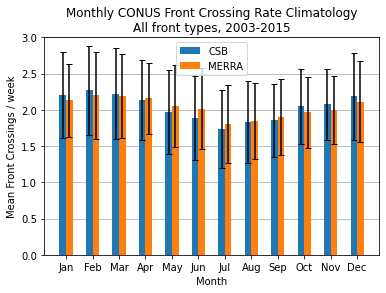

In [34]:
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
ax.bar(position, csb_mrates_clim_CONUS_mean_wk[:,4], yerr=csb_mrates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="CSB", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, merra_mrates_clim_CONUS_mean_wk[:,4], yerr=merra_mrates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="MERRA", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

# use unmasked csb to compare with merra; masked csb to compare with Jim's paper
#plt.savefig('../figures/toSCP/csb_merra_mrates_clim_CONUS_mean_wk_stdev.png')

In [37]:
merra_srates_clim_wk = merra_srates_clim*7
merra_srates_clim_CONUS_wk = merra_srates_clim_CONUS*7

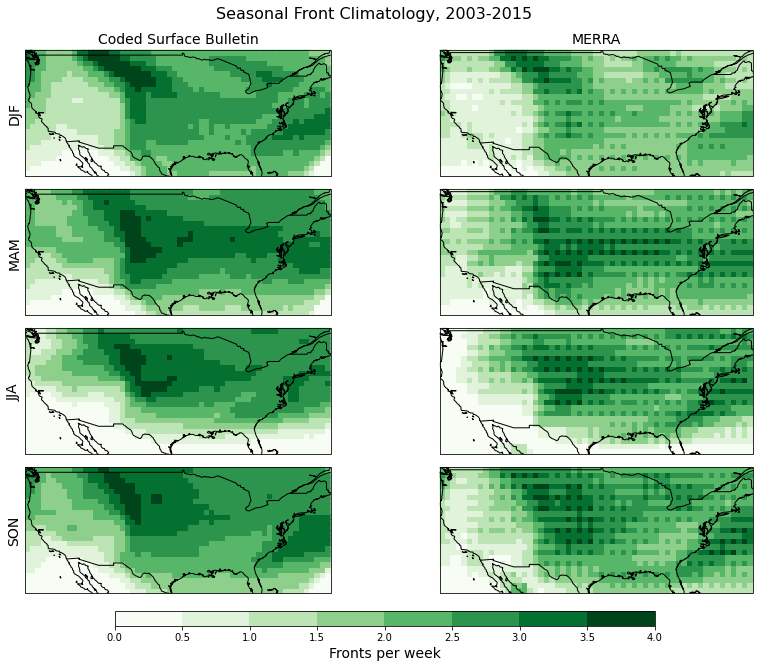

In [48]:
# by season type and trim domain to CONUS
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertCylindrical()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertConformal()}) # some of these may not be ideal for a region (the way I've subset anyway)
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.Robinson()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point(csb_srates_clim_CONUS_wk[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    lat = csb_srates_clim_CONUS.lat
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    # see also: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html#differences-pcolor-pcolormesh
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('MERRA', fontsize=14)
    field, lon = add_cyclic_point(merra_srates_clim_CONUS_wk[i,4,:,:], coord=merra_srates_clim_CONUS.lon)
    lat = merra_srates_clim_CONUS.lat
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/csb_merra_srates_clim_CONUS_viaPoly.png')

Stippling persist with MERRA data - must be an issue with generating MaskedNetCDF files from polylines. CSB files are already processed so all I do is run the rates

## Look at MERRA sample data and calculated rates

In [72]:
sample_file_path = "/glade/work/kdagon/FrontDetector/postprocessing/"
sample_rates_file = "sample_fronts_2009_FrontCrossings_viaPolylines.nc"
sample_rates_fronts = xr.open_dataset(sample_file_path+sample_rates_file)

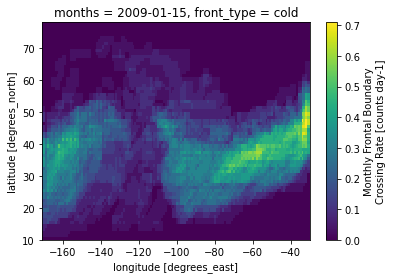

In [73]:
sample_rates_fronts.monthly_rate[0,0,:,:].plot()

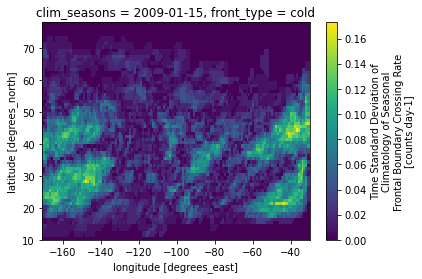

In [74]:
sample_rates_fronts.seasonal_rate_climatology_stdev[0,0,:,:].plot()

In [51]:
# rates from one-hot file
sample_OH_rates_file = "sample_fronts_2009_FrontCrossings.nc"
sample_OH_rates_fronts = xr.open_dataset(sample_file_path+sample_OH_rates_file)

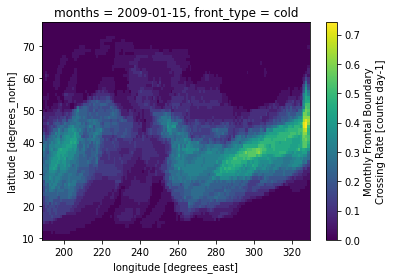

In [54]:
sample_OH_rates_fronts.monthly_rate[0,0,:,:].plot()

You can even see it in the sample single year file using the sample input data Jim provided - must be something in the polylines workflow

In [55]:
# masked netcdf file
sample_MN_fronts_file = "sample_fronts_2009_MaskedNetCDF.nc"
sample_MN_fronts = xr.open_dataset(sample_file_path+sample_MN_fronts_file)

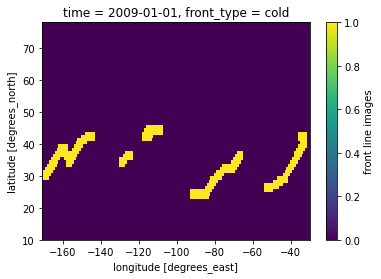

In [57]:
sample_MN_fronts.fronts.sel(time='2009-01-01',front=0)[0,:,:].plot()

## Compare MERRA / CESM, 2000-2015

In [107]:
merra_cesm_rates_file = "merra_cesm_fronts_2000-2015_frontRates_viaPolylines.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
#merra_cesm_rates_file = "merra_cesm_frontRates_2000-2015.nc" # rates calculated via OneHot file
merra_cesm_rates_fronts = xr.open_dataset(merra_file_path+merra_cesm_rates_file)

In [108]:
merra_cesm_srates_clim = merra_cesm_rates_fronts.seasonal_rate_climatology
merra_cesm_srates_clim_CONUS = merra_cesm_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
#merra_cesm_srates_clim_CONUS = merra_cesm_srates_clim.sel(lat=slice(26,50), lon=slice(235,292))
merra_cesm_srates_clim_CONUS_mean_wk = merra_cesm_srates_clim_CONUS.mean(("lon","lat"))*7 # convert counts/day to counts/wk

In [109]:
# error bars
merra_cesm_srates_clim_stdev = merra_cesm_rates_fronts.seasonal_rate_climatology_stdev
merra_cesm_srates_clim_stdev_CONUS = merra_cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
#merra_cesm_srates_clim_stdev_CONUS = merra_cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
merra_cesm_srates_clim_stdev_CONUS_mean_wk = merra_cesm_srates_clim_stdev_CONUS.mean(("lon","lat"))*7
merra_cesm_srates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.35187182, 0.33867592, 0.32023028, 0.30229986], dtype=float32)
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] ...
    front_type    object ...
Dimensions without coordinates: seasons4

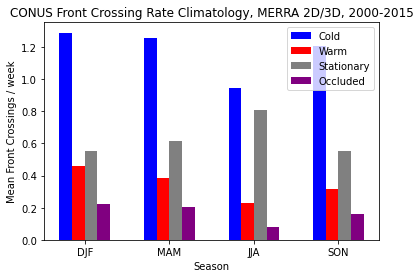

In [94]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, MERRA 2D/3D, 2000-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_srates_clim_CONUS_mean_wk.png')

In [110]:
# cesm rates calculated over full 2000-2015 period
cesm_rates_file = "cesm_fronts_2000-2015_frontRates_viaPolylines_v2.nc"
#cesm_rates_file = "cesm_frontRates_2000-2015.nc"
cesm_rates_fronts = xr.open_dataset(cesm_file_path+cesm_rates_file)

In [111]:
cesm_srates_clim = cesm_rates_fronts.seasonal_rate_climatology
#cesm_srates_clim_CONUS = cesm_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_srates_clim_CONUS = cesm_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
cesm_srates_clim_CONUS_mean_wk = cesm_srates_clim_CONUS.mean(("lon","lat"))*7 # convert counts/day to counts/wk

In [112]:
# error bars
cesm_srates_clim_stdev = cesm_rates_fronts.seasonal_rate_climatology_stdev
#cesm_srates_clim_stdev_CONUS = cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
cesm_srates_clim_stdev_CONUS = cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
cesm_srates_clim_stdev_CONUS_mean_wk = cesm_srates_clim_stdev_CONUS.mean(("lon","lat"))*7
cesm_srates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.35411987, 0.3302515 , 0.32151133, 0.32602793], dtype=float32)
Coordinates:
    clim_seasons  (seasons4) object ...
    front_type    object ...
Dimensions without coordinates: seasons4

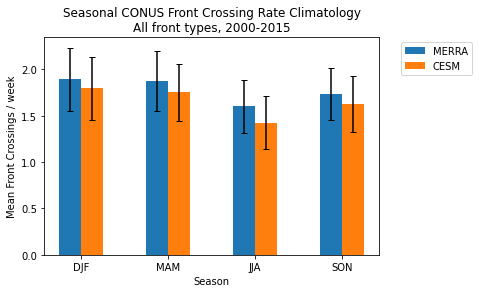

In [95]:
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk[:,4], yerr=merra_cesm_srates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="MERRA", color='C0', capsize=3)
position = x + (w/2)
ax.bar(position, cesm_srates_clim_CONUS_mean_wk[:,4], yerr=cesm_srates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="CESM", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2000-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

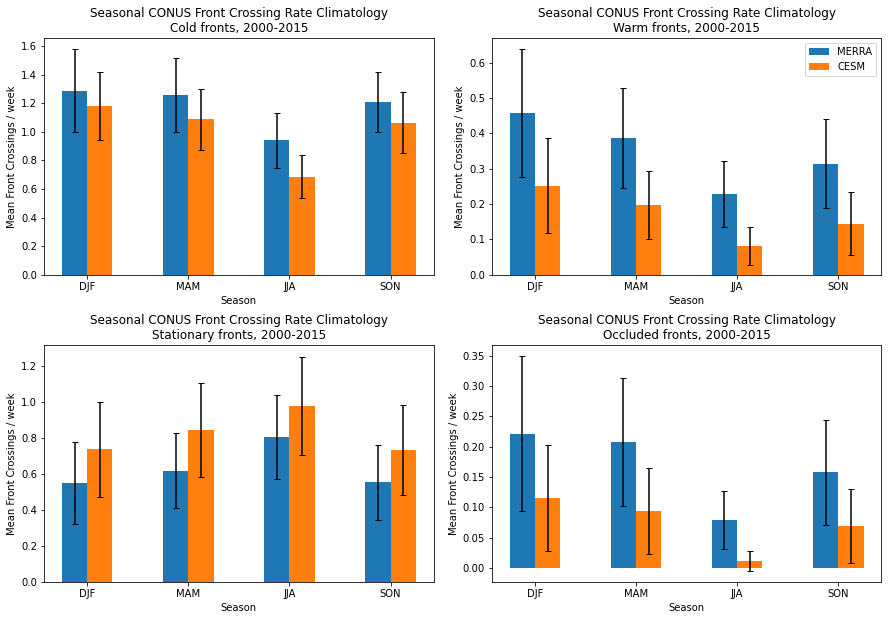

In [96]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, merra_cesm_srates_clim_CONUS_mean_wk[:,i], yerr=merra_cesm_srates_clim_stdev_CONUS_mean_wk[:,i], width=w, label="MERRA", color='C0', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, cesm_srates_clim_CONUS_mean_wk[:,i], yerr=cesm_srates_clim_stdev_CONUS_mean_wk[:,i], width=w, label="CESM", color='C1', capsize=3)

    ax[i].set_title('Seasonal CONUS Front Crossing Rate Climatology\n'+frontstrings[i]+' fronts, 2000-2015')
    ax[i].set_ylabel('Mean Front Crossings / week')
    ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_mean_wk_byfronttype_stdev.png')

In [97]:
merra_cesm_mrates_clim = merra_cesm_rates_fronts.monthly_rate_climatology
#merra_cesm_mrates_clim_CONUS_mean_wk = merra_cesm_mrates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)).mean(("lon","lat"))*7
merra_cesm_mrates_clim_CONUS_mean_wk = merra_cesm_mrates_clim.sel(lat=slice(26,50), lon=slice(235,292)).mean(("lon","lat"))*7

In [98]:
merra_cesm_mrates_clim_stdev = merra_cesm_rates_fronts.monthly_rate_climatology_stdev
#merra_cesm_mrates_clim_stdev_CONUS_mean_wk = merra_cesm_mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68)).mean(("lon","lat"))*7
merra_cesm_mrates_clim_stdev_CONUS_mean_wk = merra_cesm_mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292)).mean(("lon","lat"))*7
merra_cesm_mrates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12)>
array([0.4936058 , 0.5839382 , 0.5491007 , 0.4710613 , 0.5157847 ,
       0.51971895, 0.500892  , 0.47058332, 0.47631645, 0.48854804,
       0.46787933, 0.5253489 ], dtype=float32)
Coordinates:
    clim_months  (months12) datetime64[ns] ...
    front_type   object ...
Dimensions without coordinates: months12

In [99]:
cesm_mrates_clim = cesm_rates_fronts.monthly_rate_climatology
cesm_mrates_clim_CONUS = cesm_mrates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
#cesm_mrates_clim_CONUS = cesm_mrates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
cesm_mrates_clim_CONUS_mean_wk = cesm_mrates_clim_CONUS.mean(("lon","lat"))*7 # convert counts/day to counts/wk

In [100]:
# error bars
cesm_mrates_clim_stdev = cesm_rates_fronts.monthly_rate_climatology_stdev
cesm_mrates_clim_stdev_CONUS = cesm_mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
#cesm_mrates_clim_stdev_CONUS = cesm_mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
cesm_mrates_clim_stdev_CONUS_mean_wk = cesm_mrates_clim_stdev_CONUS.mean(("lon","lat"))*7
cesm_mrates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12)>
array([0.56150347, 0.5514723 , 0.55788034, 0.51450264, 0.5061837 ,
       0.4861285 , 0.47281227, 0.4883836 , 0.52233535, 0.48359528,
       0.48272556, 0.5414258 ], dtype=float32)
Coordinates:
    clim_months  (months12) object ...
    front_type   object ...
Dimensions without coordinates: months12

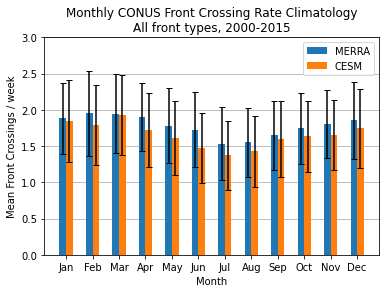

In [101]:
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
ax.bar(position, merra_cesm_mrates_clim_CONUS_mean_wk[:,4], yerr=merra_cesm_mrates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="MERRA", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, cesm_mrates_clim_CONUS_mean_wk[:,4], yerr=cesm_mrates_clim_stdev_CONUS_mean_wk[:,4], width=w, label="CESM", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology\nAll front types, 2000-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/toSCP/merra_cesm_mrates_clim_CONUS_mean_wk_stdev.png')

In [113]:
merra_cesm_srates_clim_wk = merra_cesm_srates_clim*7
merra_cesm_srates_clim_CONUS_wk = merra_cesm_srates_clim_CONUS*7

In [114]:
cesm_srates_clim_wk = cesm_srates_clim*7
cesm_srates_clim_CONUS_wk = cesm_srates_clim_CONUS*7

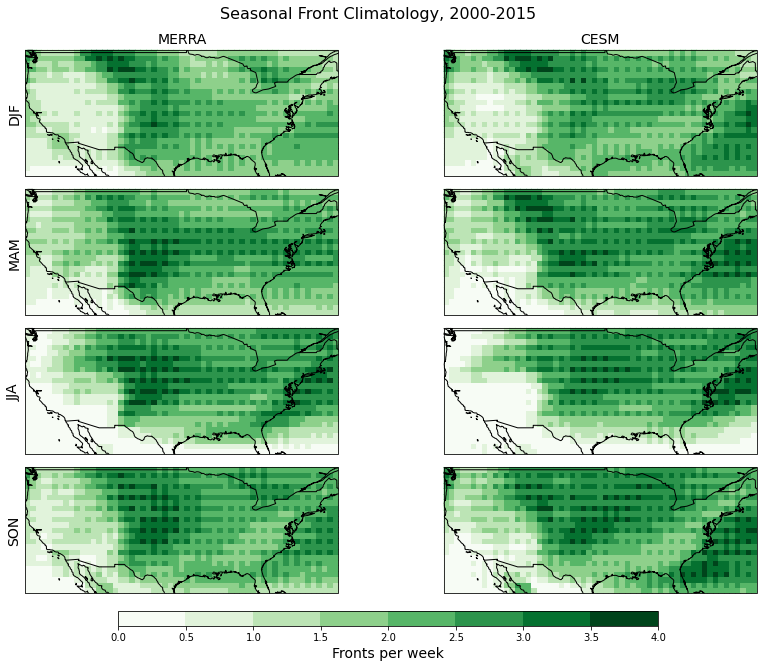

In [116]:
# by season type and trim domain to CONUS
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertCylindrical()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertConformal()}) # some of these may not be ideal for a region (the way I've subset anyway)
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.Robinson()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('MERRA', fontsize=14) 
    field, lon = add_cyclic_point(merra_cesm_srates_clim_CONUS_wk[i,4,:,:], coord=merra_cesm_srates_clim_CONUS.lon)
    lat = merra_cesm_srates_clim_CONUS.lat
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    # see also: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html#differences-pcolor-pcolormesh
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2000-2015', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CESM', fontsize=14)
    field, lon = add_cyclic_point(cesm_srates_clim_CONUS_wk[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    lat = cesm_srates_clim_CONUS.lat
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_viaPoly.png')
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_viaOH.png')

## Plots summarizing all seasonal front rate climatologies

Time Range will need to be 2003-2015 b/c CSB starts 2003\
Variants: CSB masked/unmasked, CESM polylines, CESM OH, MERRA 2D polylines, MERRA 2D OH, MERRA 2D/3D polylines, MERRA 2D/3D OH (8)

In [120]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def srates_clim_CONUS(filepath, ratesfile, gridtype):

    # read in files
    rates_fronts = xr.open_dataset(filepath+ratesfile)
    
    # process seasonal rate climatology and standard deviation
    srates_clim = rates_fronts.seasonal_rate_climatology
    srates_clim_stdev = rates_fronts.seasonal_rate_climatology_stdev
    
    # check gridtype
    if gridtype=='CESM':
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif gridtype=='MERRA':
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # convert counts/day to counts/wk
    srates_clim_CONUS_wk = srates_clim_CONUS*7
    
    # average over CONUS; convert counts/day to counts/wk
    srates_clim_CONUS_mean_wk = srates_clim_CONUS.mean(("lon","lat"))*7 
    srates_clim_stdev_CONUS_mean_wk = srates_clim_stdev_CONUS.mean(("lon","lat"))*7
    
    return(srates_clim_CONUS_wk, srates_clim_CONUS_mean_wk, srates_clim_stdev_CONUS_mean_wk)

In [200]:
# function for plotting bar chart comparing two datasets over a specified time period
def srates_clim_CONUS_barplot(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange):
    
    # call processing function
    spatial1, mean1, std1 = srates_clim_CONUS(filepath=filepath1, ratesfile=ratesfile1, gridtype=gridtype1)
    spatial2, mean2, std2 = srates_clim_CONUS(filepath=filepath2, ratesfile=ratesfile2, gridtype=gridtype2)
    
    # set up plot
    fig, ax = plt.subplots()

    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax.bar(position, mean1[:,4], yerr=std1[:,4], width=w, label=label1, color='C0', capsize=3)
    position = x + (w/2)
    ax.bar(position, mean2[:,4], yerr=std2[:,4], width=w, label=label2, color='C1', capsize=3)

    ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, '+timerange)
    ax.set_ylabel('Mean Front Crossings / week')
    ax.set_xlabel('Season')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.legend(bbox_to_anchor=(1.05, 1));
    #plt.savefig('../figures/toSCP/'+label1+'_'+label2+'_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

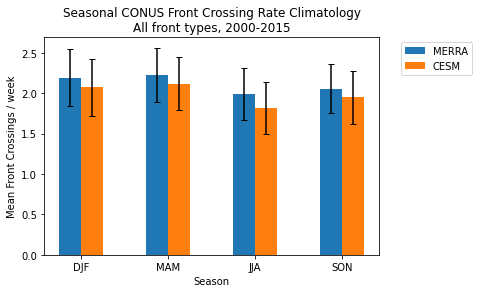

In [201]:
# example bar chart using functions above comparing two datasets

filepath1 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile1 = 'merra_cesm_fronts_2000-2015_frontRates_viaPolylines.nc'
gridtype1 = 'MERRA'
label1 = gridtype1

filepath2 = '/glade/work/kdagon/FrontDetector/CESMOutputs/'
ratesfile2 = 'cesm_fronts_2000-2015_frontRates_viaPolylines_v2.nc'
gridtype2 = 'MERRA'
label2 = 'CESM'

timerange='2000-2015'

srates_clim_CONUS_barplot(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange)

Standardize the plotting to be able to take dictionaries of filepaths and ratesfiles

In [205]:
def srates_clim_CONUS_dict_barplot(filepaths, ratesfiles, timerange):
    
    # set up storage arrays
    spatial = []
    mean = []
    std = []
    labels=[]
    
    # loop over ratesfiles
    for i,r in enumerate(ratesfiles):
        
        # assign a label for plotting
        labels.append(r)
        
        # assign filepath, gridtype based on string matching
        if "CSB" in r:
            f = filepaths["CSB"]
            g = "MERRA"          
        elif "MERRA" in r:
            f = filepaths["MERRA"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
        elif "CESM" in r:
            f = filepaths["CESM"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
            
        # call processing function    
        sp, m, sd = srates_clim_CONUS(filepath=f, ratesfile=ratesfiles[r], gridtype=g)
        spatial.append(sp)
        mean.append(m)
        std.append(sd)
    
    # set up plot
    fig, ax = plt.subplots(figsize=(15,10))
    
    # number of bars per xlabel
    nbars=len(ratesfiles)
    # width
    w = 0.75/nbars
    
    # set up xlabels
    xlabels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(xlabels)
    x = np.arange(nseason)  # the label locations

    # position based on current iteration
    for i in range(nbars):
        position = x + (w*(1-nbars)/2) + i*w
        ax.bar(position, mean[i][:,4], yerr=std[i][:,4], width=w, label=labels[i], capsize=3)
    
    ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, '+timerange, fontsize=20)
    ax.set_ylabel('Mean Front Crossings / week', fontsize=15)
    ax.set_xlabel('Season', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, fontsize=12)
    plt.yticks(fontsize=12)

    ax.legend(bbox_to_anchor=(1.05, 1), fontsize=12);
    #plt.savefig('../figures/toSCP/compare_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

In [226]:
def srates_clim_CONUS_dict_pcolorplot(filepaths, ratesfiles, timerange):
    
    # set up storage arrays
    spatial = []
    mean = []
    std = []
    labels=[]
    
    # loop over ratesfiles
    for i,r in enumerate(ratesfiles):
        
        # assign a label for plotting
        labels.append(r)
        
        # assign filepath, gridtype based on string matching
        if "CSB" in r:
            f = filepaths["CSB"]
            g = "MERRA"          
        elif "MERRA" in r:
            f = filepaths["MERRA"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
        elif "CESM" in r:
            f = filepaths["CESM"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
            
        # call processing function    
        sp, m, sd = srates_clim_CONUS(filepath=f, ratesfile=ratesfiles[r], gridtype=g)
        spatial.append(sp)
        mean.append(m)
        std.append(sd)
    
    # set up plots by season type and trim domain to CONUS
    ncols=len(ratesfiles)
    seastrings = ('DJF', 'MAM', 'JJA', 'SON')
    nsea = len(seastrings)
    fig, axs = plt.subplots(nsea, ncols, figsize=(40,10), subplot_kw={'projection': ccrs.PlateCarree()})

    # discrete colormap
    cmap=plt.cm.get_cmap('Greens', 8)
    
    # loop over ratesfiles
    for j in range(ncols):

        # loop over seasons
        for i in range(nsea):
            if i == 0:
                axs[i,j].set_title(labels[j], fontsize=20) 
            field, lon = add_cyclic_point(spatial[j][i,4,:,:], coord=spatial[j].lon)
            lat = spatial[j].lat
            cf = axs[i,j].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
            axs[i,j].coastlines()
            axs[i,j].add_feature(cfeature.BORDERS)
            if j == 0:
                axs[i,j].set_ylabel(seastrings[i], fontsize=20)
                axs[i,j].set_yticks([])
                fig.suptitle('Seasonal Front Climatology, 2000-2015', fontsize=25, y=0.94)
    
    cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
    cb1.ax.set_xlabel('Fronts per week', fontsize=20)
    cb1.ax.tick_params(labelsize=15)

    plt.subplots_adjust(wspace=0.05, hspace=0)
    #plt.savefig('../figures/toSCP/compare_srates_clim_CONUS.png')

In [203]:
# create some dictionaries for comparing multiple datasets
filepaths = {
    "CSB": "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/", 
    "MERRA": "/glade/work/kdagon/FrontDetector/MERRAOutputs/",
    "CESM": "/glade/work/kdagon/FrontDetector/CESMOutputs/"
}

# some of these have longer time period variants, sticking to 2003-2015 for consistency
ratesfiles = {
    "CSB_masked": "codsus_masked_frontRates_2003-2015.nc",
    "CSB_unmasked": "codsus_frontRates_2003-2015.nc",
    "MERRA_2D_poly": "merra_fronts_2003-2015_frontRates_viaPolylines.nc",
    "MERRA_2D_OH": "merra_frontRates_2003-2015.nc",
    "MERRA_3D_poly": "merra_cesm_fronts_2003-2015_frontRates_viaPolylines.nc",
    "MERRA_3D_OH": "merra_cesm_frontRates_2003-2015.nc",
    "CESM_poly": "cesm_fronts_2003-2015_frontRates_viaPolylines_v2.nc",
    "CESM_OH": "cesm_frontRates_2003-2015.nc"
}

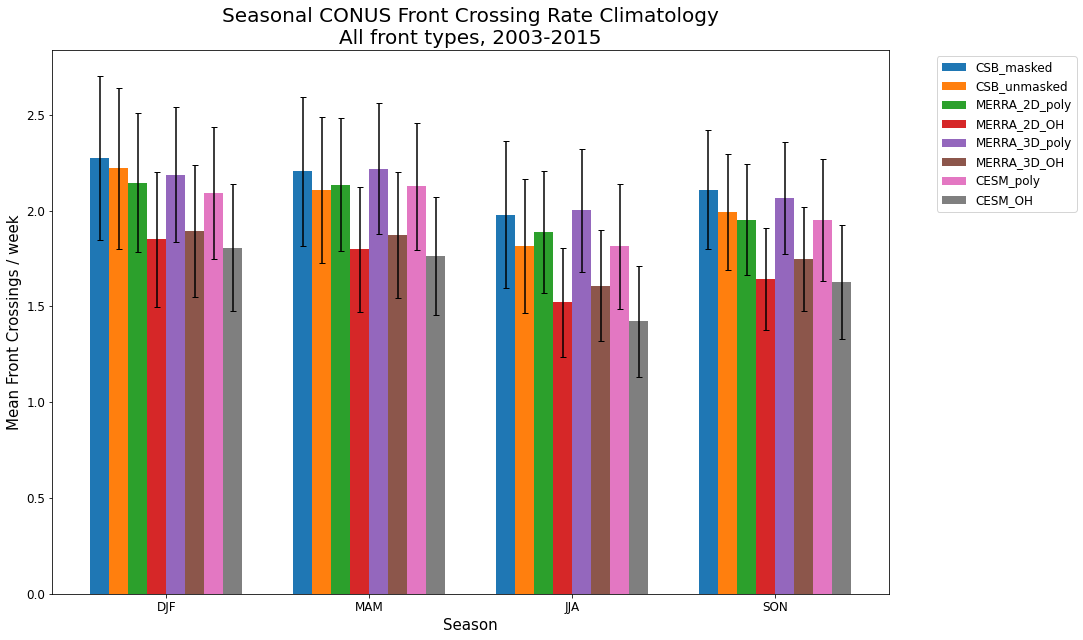

In [206]:
timerange = '2003-2015'

srates_clim_CONUS_dict_barplot(filepaths, ratesfiles, timerange)

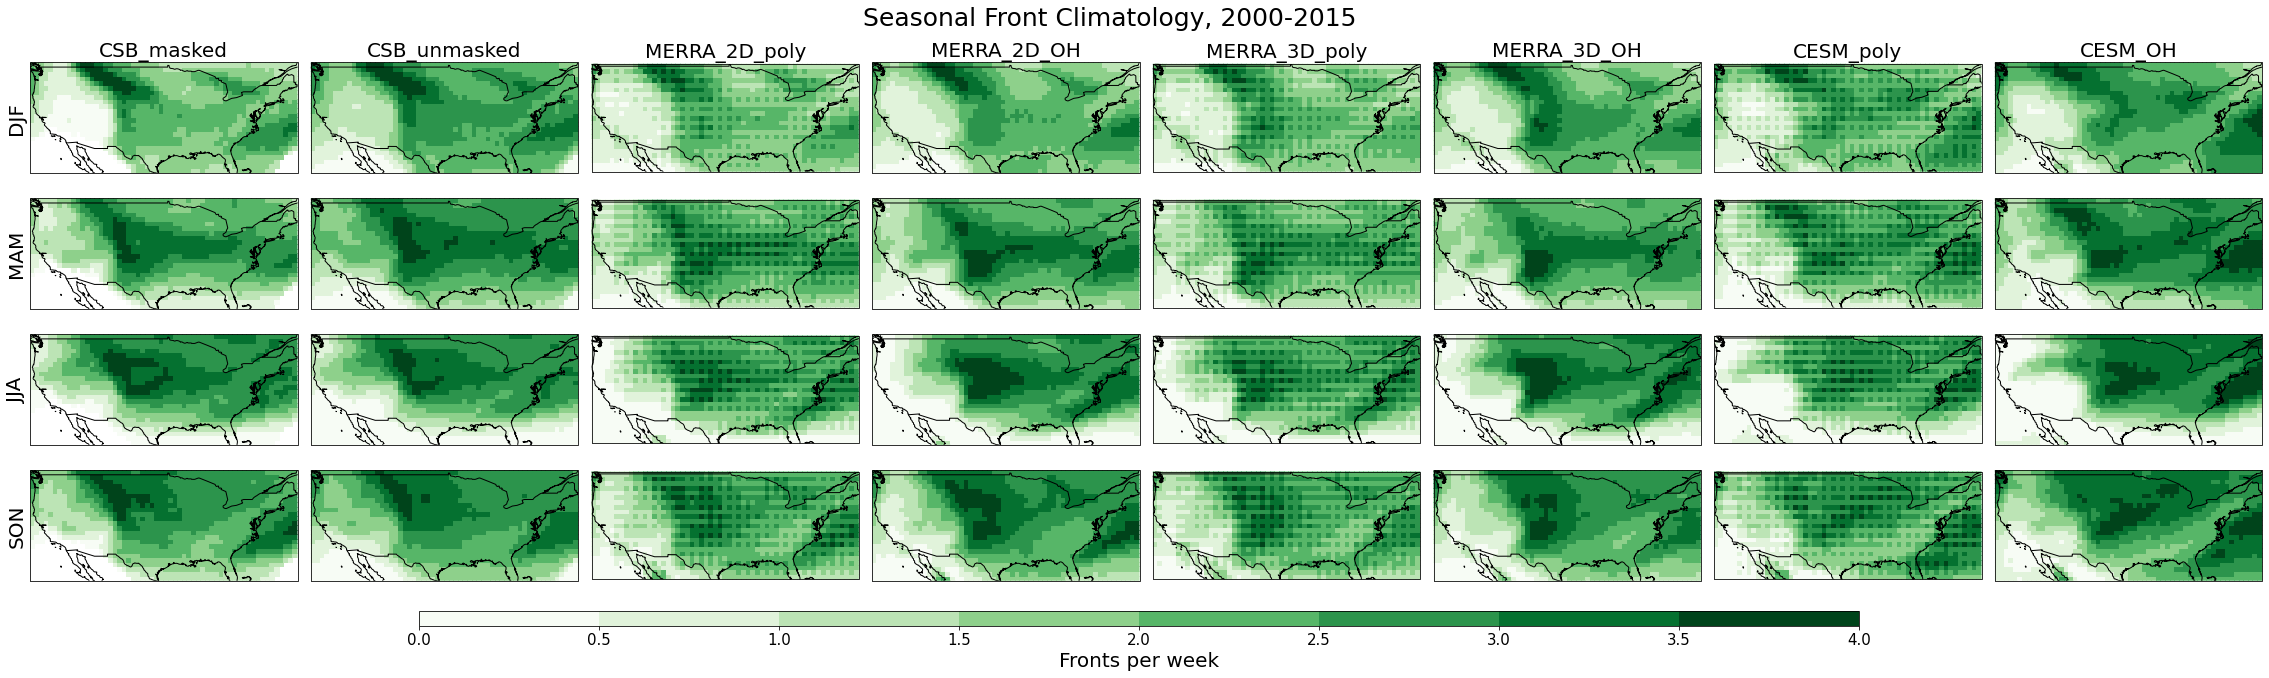

In [227]:
srates_clim_CONUS_dict_pcolorplot(filepaths, ratesfiles, timerange)

### TO DO: spatial difference plots? 

## Timeseries anomaly plots (see B&K Fig 10)

In [16]:
filepath1 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile1 = 'merra_cesm_fronts_2000-2015_frontRates_viaPolylines.nc'

rates_fronts = xr.open_dataset(filepath1+ratesfile1)

<xarray.DataArray 'months' (months: 192)>
array(['2000-01-15T00:00:00.000000000', '2000-02-15T00:00:00.000000000',
       '2000-03-15T00:00:00.000000000', '2000-04-15T00:00:00.000000000',
       '2000-05-15T00:00:00.000000000', '2000-06-15T00:00:00.000000000',
       '2000-07-15T00:00:00.000000000', '2000-08-15T00:00:00.000000000',
       '2000-09-15T00:00:00.000000000', '2000-10-15T00:00:00.000000000',
       '2000-11-15T00:00:00.000000000', '2000-12-15T00:00:00.000000000',
       '2001-01-15T00:00:00.000000000', '2001-02-15T00:00:00.000000000',
       '2001-03-15T00:00:00.000000000', '2001-04-15T00:00:00.000000000',
       '2001-05-15T00:00:00.000000000', '2001-06-15T00:00:00.000000000',
       '2001-07-15T00:00:00.000000000', '2001-08-15T00:00:00.000000000',
       '2001-09-15T00:00:00.000000000', '2001-10-15T00:00:00.000000000',
       '2001-11-15T00:00:00.000000000', '2001-12-15T00:00:00.000000000',
       '2002-01-15T00:00:00.000000000', '2002-02-15T00:00:00.000000000',
       '2002-03-15T00:00:00.000000000', '2002-04-15T00:00:00.000000000',
       '2002-05-15T00:00:00.000000000', '2002-06-15T00:00:00.000000000',
       '2002-07-15T00:00:00.000000000', '2002-08-15T00:00:00.000000000',
       '2002-09-15T00:00:00.000000000', '2002-10-15T00:00:00.000000000',
       '2002-11-15T00:00:00.000000000', '2002-12-15T00:00:00.000000000',
       '2003-01-15T00:00:00.000000000', '2003-02-15T00:00:00.000000000',
       '2003-03-15T00:00:00.000000000', '2003-04-15T00:00:00.000000000',
       '2003-05-15T00:00:00.000000000', '2003-06-15T00:00:00.000000000',
       '2003-07-15T00:00:00.000000000', '2003-08-15T00:00:00.000000000',
       '2003-09-15T00:00:00.000000000', '2003-10-15T00:00:00.000000000',
       '2003-11-15T00:00:00.000000000', '2003-12-15T00:00:00.000000000',
       '2004-01-15T00:00:00.000000000', '2004-02-15T00:00:00.000000000',
       '2004-03-15T00:00:00.000000000', '2004-04-15T00:00:00.000000000',
       '2004-05-15T00:00:00.000000000', '2004-06-15T00:00:00.000000000',
       '2004-07-15T00:00:00.000000000', '2004-08-15T00:00:00.000000000',
       '2004-09-15T00:00:00.000000000', '2004-10-15T00:00:00.000000000',
       '2004-11-15T00:00:00.000000000', '2004-12-15T00:00:00.000000000',
       '2005-01-15T00:00:00.000000000', '2005-02-15T00:00:00.000000000',
       '2005-03-15T00:00:00.000000000', '2005-04-15T00:00:00.000000000',
       '2005-05-15T00:00:00.000000000', '2005-06-15T00:00:00.000000000',
       '2005-07-15T00:00:00.000000000', '2005-08-15T00:00:00.000000000',
       '2005-09-15T00:00:00.000000000', '2005-10-15T00:00:00.000000000',
       '2005-11-15T00:00:00.000000000', '2005-12-15T00:00:00.000000000',
       '2006-01-15T00:00:00.000000000', '2006-02-15T00:00:00.000000000',
       '2006-03-15T00:00:00.000000000', '2006-04-15T00:00:00.000000000',
       '2006-05-15T00:00:00.000000000', '2006-06-15T00:00:00.000000000',
       '2006-07-15T00:00:00.000000000', '2006-08-15T00:00:00.000000000',
       '2006-09-15T00:00:00.000000000', '2006-10-15T00:00:00.000000000',
       '2006-11-15T00:00:00.000000000', '2006-12-15T00:00:00.000000000',
       '2007-01-15T00:00:00.000000000', '2007-02-15T00:00:00.000000000',
       '2007-03-15T00:00:00.000000000', '2007-04-15T00:00:00.000000000',
       '2007-05-15T00:00:00.000000000', '2007-06-15T00:00:00.000000000',
       '2007-07-15T00:00:00.000000000', '2007-08-15T00:00:00.000000000',
       '2007-09-15T00:00:00.000000000', '2007-10-15T00:00:00.000000000',
       '2007-11-15T00:00:00.000000000', '2007-12-15T00:00:00.000000000',
       '2008-01-15T00:00:00.000000000', '2008-02-15T00:00:00.000000000',
       '2008-03-15T00:00:00.000000000', '2008-04-15T00:00:00.000000000',
       '2008-05-15T00:00:00.000000000', '2008-06-15T00:00:00.000000000',
       '2008-07-15T00:00:00.000000000', '2008-08-15T00:00:00.000000000',
       '2008-09-15T00:00:00.000000000', '2008-10-15T00:00:00.000000000',
       '2008-11-15T00:00:00.000000000', '2008-12-15T00:00:00.000000000',
       '2009-01-

In [36]:
rates_fronts.monthly_rate_anomaly.groupby('months.year')

DataArrayGroupBy, grouped over 'year' 
16 groups with labels 2000, 2001, 2002, ..., 2014, 2015.

In [41]:
rates_fronts.monthly_rate_anomaly.months

<xarray.DataArray 'months' (months: 192)>
array(['2000-01-15T00:00:00.000000000', '2000-02-15T00:00:00.000000000',
       '2000-03-15T00:00:00.000000000', '2000-04-15T00:00:00.000000000',
       '2000-05-15T00:00:00.000000000', '2000-06-15T00:00:00.000000000',
       '2000-07-15T00:00:00.000000000', '2000-08-15T00:00:00.000000000',
       '2000-09-15T00:00:00.000000000', '2000-10-15T00:00:00.000000000',
       '2000-11-15T00:00:00.000000000', '2000-12-15T00:00:00.000000000',
       '2001-01-15T00:00:00.000000000', '2001-02-15T00:00:00.000000000',
       '2001-03-15T00:00:00.000000000', '2001-04-15T00:00:00.000000000',
       '2001-05-15T00:00:00.000000000', '2001-06-15T00:00:00.000000000',
       '2001-07-15T00:00:00.000000000', '2001-08-15T00:00:00.000000000',
       '2001-09-15T00:00:00.000000000', '2001-10-15T00:00:00.000000000',
       '2001-11-15T00:00:00.000000000', '2001-12-15T00:00:00.000000000',
       '2002-01-15T00:00:00.000000000', '2002-02-15T00:00:00.000000000',
       '2002-03-15T00:00:00.000000000', '2002-04-15T00:00:00.000000000',
       '2002-05-15T00:00:00.000000000', '2002-06-15T00:00:00.000000000',
       '2002-07-15T00:00:00.000000000', '2002-08-15T00:00:00.000000000',
       '2002-09-15T00:00:00.000000000', '2002-10-15T00:00:00.000000000',
       '2002-11-15T00:00:00.000000000', '2002-12-15T00:00:00.000000000',
       '2003-01-15T00:00:00.000000000', '2003-02-15T00:00:00.000000000',
       '2003-03-15T00:00:00.000000000', '2003-04-15T00:00:00.000000000',
       '2003-05-15T00:00:00.000000000', '2003-06-15T00:00:00.000000000',
       '2003-07-15T00:00:00.000000000', '2003-08-15T00:00:00.000000000',
       '2003-09-15T00:00:00.000000000', '2003-10-15T00:00:00.000000000',
       '2003-11-15T00:00:00.000000000', '2003-12-15T00:00:00.000000000',
       '2004-01-15T00:00:00.000000000', '2004-02-15T00:00:00.000000000',
       '2004-03-15T00:00:00.000000000', '2004-04-15T00:00:00.000000000',
       '2004-05-15T00:00:00.000000000', '2004-06-15T00:00:00.000000000',
       '2004-07-15T00:00:00.000000000', '2004-08-15T00:00:00.000000000',
       '2004-09-15T00:00:00.000000000', '2004-10-15T00:00:00.000000000',
       '2004-11-15T00:00:00.000000000', '2004-12-15T00:00:00.000000000',
       '2005-01-15T00:00:00.000000000', '2005-02-15T00:00:00.000000000',
       '2005-03-15T00:00:00.000000000', '2005-04-15T00:00:00.000000000',
       '2005-05-15T00:00:00.000000000', '2005-06-15T00:00:00.000000000',
       '2005-07-15T00:00:00.000000000', '2005-08-15T00:00:00.000000000',
       '2005-09-15T00:00:00.000000000', '2005-10-15T00:00:00.000000000',
       '2005-11-15T00:00:00.000000000', '2005-12-15T00:00:00.000000000',
       '2006-01-15T00:00:00.000000000', '2006-02-15T00:00:00.000000000',
       '2006-03-15T00:00:00.000000000', '2006-04-15T00:00:00.000000000',
       '2006-05-15T00:00:00.000000000', '2006-06-15T00:00:00.000000000',
       '2006-07-15T00:00:00.000000000', '2006-08-15T00:00:00.000000000',
       '2006-09-15T00:00:00.000000000', '2006-10-15T00:00:00.000000000',
       '2006-11-15T00:00:00.000000000', '2006-12-15T00:00:00.000000000',
       '2007-01-15T00:00:00.000000000', '2007-02-15T00:00:00.000000000',
       '2007-03-15T00:00:00.000000000', '2007-04-15T00:00:00.000000000',
       '2007-05-15T00:00:00.000000000', '2007-06-15T00:00:00.000000000',
       '2007-07-15T00:00:00.000000000', '2007-08-15T00:00:00.000000000',
       '2007-09-15T00:00:00.000000000', '2007-10-15T00:00:00.000000000',
       '2007-11-15T00:00:00.000000000', '2007-12-15T00:00:00.000000000',
       '2008-01-15T00:00:00.000000000', '2008-02-15T00:00:00.000000000',
       '2008-03-15T00:00:00.000000000', '2008-04-15T00:00:00.000000000',
       '2008-05-15T00:00:00.000000000', '2008-06-15T00:00:00.000000000',
       '2008-07-15T00:00:00.000000000', '2008-08-15T00:00:00.000000000',
       '2008-09-15T00:00:00.000000000', '2008-10-15T00:00:00.000000000',
       '2008-11-15T00:00:00.000000000', '2008-12-15T00:00:00.000000000',
       '2009-01-

In [6]:
# function for calculating monthly rate anomalies over CONUS (spatial field, spatial mean)
def mrates_anom_CONUS(filepath, ratesfile, gridtype):

    # read in files
    rates_fronts = xr.open_dataset(filepath+ratesfile)
    
    # process monthly rate anomaly
    mrates_anom = rates_fronts.monthly_rate_anomaly
    
    # check gridtype
    if gridtype=='CESM':
        mrates_anom_CONUS = mrates_anom.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
    elif gridtype=='MERRA':
        mrates_anom_CONUS = mrates_anom.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
    
    # convert counts/day to counts/wk
    mrates_anom_CONUS_wk = mrates_anom_CONUS*7
    
    # average over CONUS; convert counts/day to counts/wk
    mrates_anom_CONUS_mean_wk = mrates_anom_CONUS.mean(("lon","lat"))*7 
    
    return(mrates_anom_CONUS_wk, mrates_anom_CONUS_mean_wk)

In [42]:
# function for plotting timeseries comparing two datasets over a specified time period
def mrates_anom_CONUS_ts(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange):
    
    # call processing function
    spatial1, mean1 = mrates_anom_CONUS(filepath=filepath1, ratesfile=ratesfile1, gridtype=gridtype1)
    spatial2, mean2 = mrates_anom_CONUS(filepath=filepath2, ratesfile=ratesfile2, gridtype=gridtype2)
    
    # set up plot
    fig, ax = plt.subplots(figsize=(10,8))

    # TO DO: figure out how to label years at first month of each year, given data input
    #labels = np.arange(2000,2015)  # the labels

    ax.plot(mean1.months, mean1[:,4], label=label1, color='C0')
    ax.plot(mean2.months, mean2[:,4], label=label2, color='C1')

    ax.set_title('Monthly CONUS Front Crossing Rate Anomaly\nAll front types, '+timerange)
    ax.set_ylabel('Mean Front Crossing Rate Anomaly / week')
    #ax.set_xlabel('Year')
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)

    ax.legend()
    #plt.savefig('../figures/toSCP/'+label1+'_'+label2+'_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

In [44]:
from matplotlib.dates import DateFormatter
import nc_time_axis

ModuleNotFoundError: No module named 'nc_time_axis'

In [ ]:
# example timeseries using functions above comparing two datasets

filepath1 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile1 = 'merra_cesm_fronts_2000-2015_frontRates_viaPolylines.nc'
gridtype1 = 'MERRA'
label1 = gridtype1

filepath2 = '/glade/work/kdagon/FrontDetector/CESMOutputs/'
ratesfile2 = 'cesm_fronts_2000-2015_frontRates_viaPolylines_v2.nc'
gridtype2 = 'MERRA'
label2 = 'CESM'

timerange='2000-2015'

mrates_anom_CONUS_ts(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange)